## Packages used that are not included in Jupyter Notebook.

Fuzzywuzzy-- string matching using Levenshtein Distance to calculate the differences between strings


https://pypi.python.org/pypi/fuzzywuzzy


Cartopy--  a Python package designed to make drawing maps for data analysis and visualisation as easy as possible

http://scitools.org.uk/cartopy/docs/v0.15/installing.html#installing

Geopy-- locates the coordinates of addresses, cities, countries, and landmarks across the globe using third-party geocoders and other data sources

https://pypi.python.org/pypi/geopy

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import requests
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import shapely.geometry as sgeom
import cartopy.io.shapereader as shpreader
import cartopy
import pickle
from geopy.geocoders import Nominatim
% matplotlib inline

/Users/jeanettejin/anaconda/lib/python3.6/site-packages/fuzzywuzzy/fuzz.py:35: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


# FBI Data

Here, we scrape from the FBI webpage, getting the hyperlinks for each year, and then we naviagate to violent crimes and murders, getting the URL for each year's MSA table.

In [2]:
# Code that scrapes data from each webpage for each year 

## for each year
req = requests.get("https://ucr.fbi.gov/ucr-publications")
page = req.text
soup = BeautifulSoup(page, 'html.parser')

# scrape links from main website
links = []
span = soup.find_all('span', class_= 'castle-body')[4]
a = span.find_all('a')

for link in a:
    links.append(link['href'])
links = links[0:11]
links

# redefine link for 09
links[7] = 'https://www2.fbi.gov/ucr/cius2009/index.html'

## going to violent crimes
violence = []

for link in links: 
    req = requests.get(link)
    page = req.text
    soup = BeautifulSoup(page, 'html.parser')
    href = soup.find_all('a', href = True, text = 'Violent Crime')[0]['href']
    if 'https' in href:
        violence.append(href)
        
    else:
        if 'index.html' in link:
            link = link.replace('index.html', '')
            violence.append(link + href)
        else:
            violence.append(link + '/' + href)
            
## going to MSA table
table = []
for v in violence:
    page = requests.get(v).text
    soup = BeautifulSoup(page, 'html.parser')
    a = soup.find_all('a', href = True)
    for i in a:   
        if 'Statistical Areas' in i.text:
            if 'https' in i['href']:
                table.append(i['href'])
            else:
                if 'violent_crime' in v:
                    v = v.replace('offenses/violent_crime/index.html','')
                    table.append(v + 'data/table_06.html')
table


['https://ucr.fbi.gov/crime-in-the-u.s/2016/crime-in-the-u.s.-2016/tables/table-4',
 'https://ucr.fbi.gov/crime-in-the-u.s/2015/crime-in-the-u.s.-2015/tables/table-6',
 'https://ucr.fbi.gov/crime-in-the-u.s/2014/crime-in-the-u.s.-2014/tables/table-6',
 'https://ucr.fbi.gov/crime-in-the-u.s/2013/crime-in-the-u.s.-2013/tables/6tabledatadecpdf/table-6',
 'https://ucr.fbi.gov/crime-in-the-u.s/2012/crime-in-the-u.s.-2012/tables/6tabledatadecpdf',
 'https://ucr.fbi.gov/crime-in-the-u.s/2011/crime-in-the-u.s.-2011/tables/table-6',
 'https://ucr.fbi.gov/crime-in-the-u.s/2010/crime-in-the-u.s.-2010/tables/table-6',
 'https://www2.fbi.gov/ucr/cius2009/data/table_06.html',
 'http://www2.fbi.gov/ucr/cius2008/data/table_06.html',
 'http://www2.fbi.gov/ucr/cius2007/data/table_06.html',
 'http://www2.fbi.gov/ucr/cius2006/data/table_06.html']

We define a function to parse the tables for each year. This function was adapted from http://srome.github.io/Parsing-HTML-Tables-in-Python-with-BeautifulSoup-and-pandas/, but makes many changes to td/th tag checks, dataframe indexing, changes to find the dimensions of the dataframe, and changes to float/int recast. 

In [3]:
# Adapted from http://srome.github.io/Parsing-HTML-Tables-in-Python-with-BeautifulSoup-and-pandas/
# changes to td/th checks
# changes to dataframe indexing
# changes to how we find dim of dataframe
# changes to float/int recast


def parse_table(table):
        n_columns = 0
        n_rows = 0
        column_names = []

        # Find number of rows and columns
        # we also find the column titles if we can
        colidx = 0
        rows = table.find_all('tr')
        n_rows = len(rows)-1
        td_tags = rows[0].find_all('td')
        th_tags = rows[0].find_all('th')
        n_columns = len(th_tags) + len(td_tags)
        for th in th_tags:
            column_names.append(th.get_text().strip())
        
        # Safeguard on Column Titles
        if len(column_names) > 0 and len(column_names) != n_columns:
            raise Exception("Column titles do not match the number of columns")

        columns = column_names if len(column_names) > 0 else range(0,n_columns)
        df = pd.DataFrame(columns = columns,
                          index= range(0,n_rows))
        row_marker = 0

        # find all rows and iterate over each row (skip first row- those are the columns!)
        for row in rows[1:]:
            # check if 2 th's (means at Abilene)
            numb_cols = len(row.find_all('td')) + len(row.find_all('th'))
            if numb_cols == n_columns:
                column_marker = 0
            else:
                df.iat[row_marker,0] = ''
                column_marker = 1
                
        # find each column header (there are 2 column headers and 10 td's)
            colheads = row.find_all('th')
            if row_marker == 0:
                print(df.iat[0,0])
            for colhead in colheads:
                df.iat[row_marker,column_marker] = colhead.get_text().strip()
                column_marker+=1
                
        # find the 10 td's and append to dataframe
            columns = row.find_all('td')
            for column in columns:
                df.iat[row_marker,column_marker] = column.get_text().strip()
                column_marker += 1
            if len(columns) > 0:
                row_marker += 1
        
        return df

We use the function defined above to scape all elements in the table and store them in a dictionary of dataframes with keys = year

In [4]:
# store the tables in a dictionary with key = year
yeartbl = {}
year = 2016
for t in table:
    print(year)
    page = requests.get(t).text
    soup = BeautifulSoup(page, 'lxml')
    i = 0
    # pick the first table with many rows
    while len(soup.find_all('table')[i].find_all('tr')) < 200:
        i += 1
        print(i)
    a = soup.find_all('table')[i]
    tempdf = parse_table(a)
    yeartbl[year] = tempdf
    year = year - 1

2016
nan
2015
nan
2014
nan
2013
1
nan
2012
1
nan
2011
1
nan
2010
1
nan
2009
nan
2008
nan
2007
nan
2006
nan


An example:

In [5]:
yeartbl[2006].head()

Metropolitan Statistical Area  \
0           Abilene, TX M.S.A.1   
1                                 
2                                 
3                                 
4                                 

                        Counties/principal cities Population Violent crime  \
0                                                    162,776                 
1  Includes Callahan,1 Jones, and Taylor Counties                            
2                                 City of Abilene    118,009           554   
3                   Total area actually reporting     100.0%           638   
4                    Rate per 100,000 inhabitants                    391.9   

  Murder and nonnegligent manslaughter Forcible rape Robbery  \
0                                                              
1                                                              
2                                    5            67     107   
3                                    6            75     109   
4                                  3.7          46.1    67.0   

  Aggravated assault Property crime Burglary Larceny-theft Motor vehicle theft  
0                                                                               
1                                                                               
2                375          5,045    1,282         3,460                 303  
3                448          5,741    1,531         3,852                 358  
4              275.2        3,526.9    940.6       2,366.4               219.9

Changing column names:

In [6]:
# replace old column names with easier to use
new_col_names = ['MSA', 'Counties', 'Population', 'Violent_Crime', 'Murder', 'Rape', 'Robbery', 'Assault', 'Property_Crime', 'Burglary', 'Larceny',
    'Vehicle_Theft']

i = 2016

while i != 2005:
    yeartbl[i].columns = new_col_names
    i = i-1


    

We are only interested in the MSA and its murder counts for each year. For each table in our dictionary we find this information and put them into another dictionary of dataframe with key = year

In [7]:
# since we only care about murder at the moment lets change the type to numeric
i = 2016

murder_stats = {}
while i != 2005:    
    temp = yeartbl[i]
    
    # remove commas to change type
    temp['Murder'] = temp['Murder'].str.replace(",", "")
    temp['Murder'] = pd.to_numeric(temp['Murder'])
    temp['MSA'][temp['MSA'] == ''] = np.NaN
    temp['MSA'] = temp['MSA'].fillna(method = 'ffill')
    murders = temp[temp["Counties"].str.contains("Total area actually reporting")][['MSA','Murder']]
    murder_stats[i] = murders
    i = i - 1

/Users/jeanettejin/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


An example:

In [8]:
murder_stats[2006].head()

MSA  Murder
3                  Abilene, TX M.S.A.1     6.0
8                    Albany, GA M.S.A.    11.0
16  Albany-Schenectady-Troy, NY M.S.A.    18.0
21              Albuquerque, NM M.S.A.    72.0
27               Alexandria, LA M.S.A.    10.0

In [9]:
# lengths of each dataframe
for i in range(2006,2017):
    print(len(murder_stats[i]))
    

357
364
357
378
368
376
389
384
377
377
386


# Census Data

We download csv files of for year 2006 - 2016 for the following features take from the Census Data by each MSA

S0101: Age and Sex <br />
S1201: Marital Status <br />
S1501: Educational Attainment <br />
S1701: Poverty Status in the Past 12 Months <br />
S1903: Median income in the past 12 months <br />
B02001: Race  <br />
B01003: Total Population <br />

Below we define some functions to help us with the cleaning process:

In [10]:
# makes the df column names the first row 
def rename(df):
    header = df.iloc[0]
    df = df.iloc[1:]
    df = df.rename(columns = header)
    return df

# names of the csv files
def makefile_names(code, some_list):
    for i in list(range(6, 17)):
            num = "%02d" % (i,)
            if i == 6:
                some_list.append('Census Data/ACS_06_EST_' + code + '_with_ann.csv')
            else:
                some_list.append('Census Data/ACS_' + num  + '_1YR_' + code + '_with_ann.csv')
    return some_list

In [11]:
# the codes of each feature
codes = ['S0101', 'S1201', 'S1501', 'S1701', 'S1903', 'B02001','B01003']

filenames = {}

names = ['age_sex', 'marital', 'education', 'poverty', 'income', 'race', 'population'] 

for i in range(0, len(names)):
    list_name = []
    filenames[names[i]] = makefile_names(codes[i], list_name)
    

# Feature: Population

We use the first feature population to put each MSA into a dictionary with key = unique identifier. For each year we iterate through the dataframe's MSA and check to see if it exists within our dictionary. If not, we add it to our dictionary. This ensures that we will have nan values for MSAs that do not appear throughout all the years. 

In [12]:
dict_pop_year = {}

# make a dict of dict with each being {msa_code: population_year}
for i in range(0, len(filenames['population'])):
    
    # load as df
    df_pop_year = pd.read_csv(filenames['population'][i], encoding = "ISO-8859-1")
    print(len(df_pop_year))
    
    # clean
    df_pop_year = rename(df_pop_year)
    df_pop_year[['Id2']] = df_pop_year[['Id2']].astype(int)
    df_pop_year['Geography'] = df_pop_year['Geography'].str.replace(' Metro Area', '')

    # make a dict of id and name of msa
    if i == 0:
        msa_dict = dict(zip(df_pop_year['Id2'], df_pop_year['Geography']))
      
    else:
        for code,name in zip(df_pop_year['Id2'], df_pop_year['Geography']):
            msa_dict.setdefault(code, name)

    dict_pop = dict(zip(df_pop_year['Id2'], df_pop_year['Estimate; Total']))
    dict_pop_year['pop' + "_%02d" % (i + 6,)] = dict_pop
    
# printed are the number of unique msa's per year!

368
370
370
375
375
375
375
389
389
389
390


We use the dictionary with key = Unique idenitifier and value the names of the MSA and create a df with all of the populations for each year.

In [13]:
# make dataframe using dict keys
msa_df = pd.DataFrame.from_dict(msa_dict, orient = 'index')
msa_df.columns = ['msa_name']

# add to dict using keys
for key in dict_pop_year:
    msa_df[key] = pd.Series(dict_pop_year[key])

# show
msa_df.head()



msa_name  pop_06  pop_07  pop_08  pop_09  \
10180                          Abilene, TX  158548  159439  160012  160266   
10380  Aguadilla-Isabela-San Sebastián, PR  336502  335201  339193  342495   
10420                            Akron, OH  700943  699356  698553  699935   
10500                           Albany, GA  165062  162767  163074  164238   
10580          Albany-Schenectady-Troy, NY  850957  853358  853919  857592   

       pop_10  pop_11  pop_12  pop_13  pop_14  pop_15  pop_16  
10180  164941  165858  167800  168144  166900  168922  170860  
10380  305988  304633  304727  327847  322079  313209  309764  
10420  702951  701456  702262  705686  703825  704243  702221  
10500  162659  161617  155019  156277  152596  156997  152506  
10580  870832  871478  874646  877905  880167  881830  881839

We do this for every feature using the unique identifier to add features to our dataframe

# Feature: Sex and Year``

In [14]:
dict_agesex_year = {}

for i in range(0, len(filenames['age_sex'])):
    
    # load and clean
    df_agesex_year = pd.read_csv(filenames['age_sex'][i], encoding = 'ISO-8859-1')
    df_agesex_year = rename(df_agesex_year)
    
    # get columns names
    gender_columns = ['Male; Estimate; Total population', 'Female; Estimate; Total population']
    age_columns = [x for x in df_agesex_year.columns.values.tolist() if x.startswith("Total; Estimate; Total population - AGE")]
    if len(age_columns) == 0:
        age_columns = df_agesex_year.columns[df_agesex_year.columns.str.contains('Total; Estimate; AGE')].tolist()
    int_columns = gender_columns + ['Total; Estimate; Total population', 'Id2']
    
    # change type
    df_agesex_year[int_columns] = df_agesex_year[int_columns].astype(int)
    df_agesex_year[age_columns] = df_agesex_year[age_columns].astype(float)
    
    # make a column for the percent of male and females in each msa
    df_agesex_year['Percent_male'] = df_agesex_year[gender_columns[0]] / df_agesex_year['Total; Estimate; Total population']
    df_agesex_year['Percent_female'] = df_agesex_year[gender_columns[1]] / df_agesex_year['Total; Estimate; Total population']
    
    # select columns
    add_columns_agesex = ['Percent_male', 'Percent_female'] + age_columns
    
    # fill dict
    for feature in add_columns_agesex:
        dict_agesex = dict(zip(df_agesex_year['Id2'], df_agesex_year[feature]))
        dict_agesex_year[feature + "_%02d" % (i + 6,) ] = dict_agesex
        
# add to dataframe   
for key in dict_agesex_year:
     msa_df[key] = pd.Series(dict_agesex_year[key])

# rename and show
msa_df.columns = msa_df.columns.str.replace('Total; Estimate; ', '')
msa_df.columns = msa_df.columns.str.replace('Total population - ', '')
msa_df.head()

msa_name  pop_06  pop_07  pop_08  pop_09  \
10180                          Abilene, TX  158548  159439  160012  160266   
10380  Aguadilla-Isabela-San Sebastián, PR  336502  335201  339193  342495   
10420                            Akron, OH  700943  699356  698553  699935   
10500                           Albany, GA  165062  162767  163074  164238   
10580          Albany-Schenectady-Troy, NY  850957  853358  853919  857592   

       pop_10  pop_11  pop_12  pop_13  pop_14             ...              \
10180  164941  165858  167800  168144  166900             ...               
10380  305988  304633  304727  327847  322079             ...               
10420  702951  701456  702262  705686  703825             ...               
10500  162659  161617  155019  156277  152596             ...               
10580  870832  871478  874646  877905  880167             ...               

      AGE - 40 to 44 years_16 AGE - 45 to 49 years_16  \
10180                     4.4                     5.3   
10380                     6.0                     6.4   
10420                     5.5                     6.5   
10500                     5.4                     5.6   
10580                     5.6                     6.7   

       AGE - 50 to 54 years_16  AGE - 55 to 59 years_16  \
10180                      6.2                      5.2   
10380                      6.5                      6.5   
10420                      7.3                      7.4   
10500                      6.1                      6.6   
10580                      7.3                      7.5   

       AGE - 60 to 64 years_16  AGE - 65 to 69 years_16  \
10180                      5.9                      5.3   
10380                      6.6                      6.4   
10420                      6.9                      5.7   
10500                      6.6                      5.6   
10580                      6.3                      5.6   

       AGE - 70 to 74 years_16  AGE - 75 to 79 years_16  \
10180                      3.3                      2.7   
10380                      5.0                      3.5   
10420                      3.9                      2.8   
10500                      3.3                      2.4   
10580                      3.8                      2.2   

       AGE - 80 to 84 years_16  AGE - 85 years and over_16  
10180                      2.1                         1.8  
10380                      2.1                         1.8  
10420                      1.9                         2.4  
10500                      2.0                         1.5  
10580                      2.0                         2.6  

[5 rows x 232 columns]

# Feature: Marriage Status

In [15]:
dict_marital_year = {}

for i in range(0, len(filenames['marital'])):
    
    # load and clean
    df_marital = pd.read_csv(filenames['marital'][i], encoding='cp1252')
    df_marital = rename(df_marital)
    df_marital = df_marital.loc[:,~df_marital.columns.duplicated()]
    df_marital = df_marital.replace("N", np.nan)
    
    
    # features
    status_columns = ['Now married (except separated); Estimate; Population 15 years and over', 'Widowed; Estimate; Population 15 years and over', 'Divorced; Estimate; Population 15 years and over', 'Separated; Estimate; Population 15 years and over', 'Never married; Estimate; Population 15 years and over']

    # change type
    df_marital[status_columns] = df_marital[status_columns].astype(float)
    df_marital['Id2'] = df_marital['Id2'].astype(float)
    
    # fill dict with dicts
    for feature in status_columns:
            dict_marital = dict(zip(df_marital['Id2'], df_marital[feature]))
            dict_marital_year[feature + "_%02d" % (i + 6,) ] = dict_marital
        

            
# add to df
for key in dict_marital_year:
    msa_df[key] = pd.Series(dict_marital_year[key])

# clean column names and show
msa_df.columns = msa_df.columns.str.replace('; Estimate; Population 15 years and over', '')
msa_df.columns = msa_df.columns.str.replace('except separated', '')
msa_df.head()

msa_name  pop_06  pop_07  pop_08  pop_09  \
10180                          Abilene, TX  158548  159439  160012  160266   
10380  Aguadilla-Isabela-San Sebastián, PR  336502  335201  339193  342495   
10420                            Akron, OH  700943  699356  698553  699935   
10500                           Albany, GA  165062  162767  163074  164238   
10580          Albany-Schenectady-Troy, NY  850957  853358  853919  857592   

       pop_10  pop_11  pop_12  pop_13  pop_14        ...         \
10180  164941  165858  167800  168144  166900        ...          
10380  305988  304633  304727  327847  322079        ...          
10420  702951  701456  702262  705686  703825        ...          
10500  162659  161617  155019  156277  152596        ...          
10580  870832  871478  874646  877905  880167        ...          

      Now married ()_15 Widowed_15  Divorced_15  Separated_15  \
10180              45.4        6.6         12.0           3.3   
10380              41.7        7.1         12.0           3.8   
10420              46.7        6.3         11.9           1.3   
10500              39.4        7.8         12.6           5.2   
10580              45.1        5.9          9.8           1.9   

       Never married_15  Now married ()_16  Widowed_16  Divorced_16  \
10180              32.8               46.8         5.5         10.9   
10380              35.3               39.5         7.2         12.6   
10420              33.8               46.9         5.9         11.5   
10500              35.0               39.8         6.8         12.0   
10580              37.2               44.2         6.5         10.2   

       Separated_16  Never married_16  
10180           2.5              34.2  
10380           3.1              37.7  
10420           1.6              34.1  
10500           3.3              38.2  
10580           2.2              36.9  

[5 rows x 287 columns]

# Feature: Education

In [16]:
dict_education_year = {}

for i in range(0, len(filenames['education'])):
    
    # load and clean
    df_education = pd.read_csv(filenames['education'][i], encoding='cp1252')
    df_education = rename(df_education)


    # features (gov naming conventions suck)
    if i < 4:
        education_columns = ['Total; Estimate; Population 25 years and over - Percent high school graduate or higher', "Total; Estimate; Population 25 years and over - Percent bachelor's degree or higher"]

    if 4 <= i <= 8:
        education_columns = ['Total; Estimate; Percent high school graduate or higher', "Total; Estimate; Percent bachelor's degree or higher"]  
        
    if i > 8: 
        education_columns = ['Percent; Estimate; Percent high school graduate or higher', "Percent; Estimate; Percent bachelor's degree or higher"]
        
    # change datatype
    df_education[education_columns] = df_education[education_columns].astype(float)
    df_education['Id2'] = df_education['Id2'].astype(int)

    # create dict of dicts
    for feature in education_columns:
        dict_education = dict(zip(df_education['Id2'], df_education[feature]))
        dict_education_year[feature + "_%02d" % (i + 6,) ] = dict_education
        
# add to dataframe        
for key in dict_education_year:
    msa_df[key] = pd.Series(dict_education_year[key])

# clean column names and show
msa_df.columns = msa_df.columns.str.replace('Total; Estimate;', '')
msa_df.columns = msa_df.columns.str.replace('Percent; Estimate;', '')
msa_df.columns = msa_df.columns.str.replace('Population 25 years and over - ', '')
msa_df.head()

msa_name  pop_06  pop_07  pop_08  pop_09  \
10180                          Abilene, TX  158548  159439  160012  160266   
10380  Aguadilla-Isabela-San Sebastián, PR  336502  335201  339193  342495   
10420                            Akron, OH  700943  699356  698553  699935   
10500                           Albany, GA  165062  162767  163074  164238   
10580          Albany-Schenectady-Troy, NY  850957  853358  853919  857592   

       pop_10  pop_11  pop_12  pop_13  pop_14  \
10180  164941  165858  167800  168144  166900   
10380  305988  304633  304727  327847  322079   
10420  702951  701456  702262  705686  703825   
10500  162659  161617  155019  156277  152596   
10580  870832  871478  874646  877905  880167   

                        ...                     \
10180                   ...                      
10380                   ...                      
10420                   ...                      
10500                   ...                      
10580                   ...                      

       Percent high school graduate or higher_12  \
10180                                       83.5   
10380                                       66.0   
10420                                       90.6   
10500                                       79.9   
10580                                       92.0   

       Percent bachelor's degree or higher_12  \
10180                                    21.2   
10380                                    20.5   
10420                                    28.4   
10500                                    18.4   
10580                                    34.1   

        Percent high school graduate or higher_13  \
10180                                        83.8   
10380                                        63.3   
10420                                        91.1   
10500                                        80.1   
10580                                        92.1   

        Percent bachelor's degree or higher_13  \
10180                                     22.1   
10380                                     18.2   
10420                                     29.7   
10500                                     16.4   
10580                                     34.3   

        Percent high school graduate or higher_14  \
10180                                        86.1   
10380                                        67.6   
10420                                        91.1   
10500                                        81.5   
10580                                        92.5   

        Percent bachelor's degree or higher_14  \
10180                                     21.6   
10380                                     19.8   
10420                                     29.9   
10500                                     19.0   
10580                                     35.4   

        Percent high school graduate or higher_15  \
10180                                        87.7   
10380                                        68.7   
10420                                        91.5   
10500                                        82.3   
10580                                        92.2   

        Percent bachelor's degree or higher_15  \
10180                                     20.7   
10380                                     20.4   
10420                                     30.1   
10500                                     21.1   
10580                                     35.3   

        Percent high school graduate or higher_16  \
10180                                        86.7   
10380                                        67.3   
10420                                        91.8   
10500                                        84.8   
10580                                        91.6   

        Percent bachelor's degree or higher_16  
10180                                     20.4  
10380                                     17.8  
10420                              

# Feature Poverty

In [17]:
dict_poverty_year = {}

for i in range(0, len(filenames['poverty'])):

    # load and clean
    df_poverty = pd.read_csv(filenames['poverty'][i], encoding='cp1252')
    df_poverty = rename(df_poverty)
    
    # find column name and set (a difference of a space between percent and below...)
    a = 'Percent  below poverty level; Estimate; Population for whom poverty status is determined'
    b = 'Percent below poverty level; Estimate; Population for whom poverty status is determined'
    
    if a in df_poverty:
        poverty_column = a

    if b in df_poverty:
        poverty_column = b

    # change dtype
    df_poverty[poverty_column] = df_poverty[poverty_column].astype(float)
    df_poverty['Id2'] = df_poverty['Id2'].astype(int)
    
    # make a dict of dicts
    dict_poverty = dict(zip(df_poverty['Id2'], df_poverty[poverty_column]))
    dict_poverty_year['poverty' + "_%02d" % (i + 6,) ] = dict_poverty

# add each dict in dict to msa df
for key in dict_poverty_year:
    msa_df[key] = pd.Series(dict_poverty_year[key])

msa_df.head()

msa_name  pop_06  pop_07  pop_08  pop_09  \
10180                          Abilene, TX  158548  159439  160012  160266   
10380  Aguadilla-Isabela-San Sebastián, PR  336502  335201  339193  342495   
10420                            Akron, OH  700943  699356  698553  699935   
10500                           Albany, GA  165062  162767  163074  164238   
10580          Albany-Schenectady-Troy, NY  850957  853358  853919  857592   

       pop_10  pop_11  pop_12  pop_13  pop_14     ...     poverty_07  \
10180  164941  165858  167800  168144  166900     ...           15.1   
10380  305988  304633  304727  327847  322079     ...           57.6   
10420  702951  701456  702262  705686  703825     ...           13.4   
10500  162659  161617  155019  156277  152596     ...           21.5   
10580  870832  871478  874646  877905  880167     ...           10.1   

      poverty_08  poverty_09  poverty_10  poverty_11  poverty_12  poverty_13  \
10180       16.1        14.5        18.0        16.9        20.5        16.8   
10380       54.5        55.4        53.8        54.0        53.7        53.8   
10420       12.1        14.7        15.5        16.6        15.7        15.4   
10500       23.3        23.2        27.7        28.4        26.9        24.9   
10580       10.5         9.9        11.5        11.5        11.0        12.5   

       poverty_14  poverty_15  poverty_16  
10180        16.5        13.9        17.2  
10380        53.4        53.7        54.1  
10420        13.3        14.2        13.8  
10500        25.3        24.6        25.0  
10580        11.7        10.2         9.9  

[5 rows x 320 columns]

# Feature: Income`

In [18]:
dict_income_year = {}

for i in range(0, len(filenames['income'])):
    
    # load and clean
    df_income = pd.read_csv(filenames['income'][i], encoding = 'cp1252')
    df_income = rename(df_income)

    # get column name
    income_column = [x for x in df_income.columns.values.tolist() if x.startswith('Median income (dollars); Estimate; H')][0]
 
    # dtypes
    df_income[income_column] = df_income[income_column].astype(float)
    df_income['Id2'] = df_income['Id2'].astype(int)
    
    # dict of dicts
    dict_income = dict(zip(df_income['Id2'], df_income[income_column]))
    dict_income_year['median_income' + "_%02d" % (i + 6,) ] = dict_income
    
# add each dict in dict to msa df    
for key in dict_income_year:
    msa_df[key] = pd.Series(dict_income_year[key])
    
msa_df.head()

msa_name  pop_06  pop_07  pop_08  pop_09  \
10180                          Abilene, TX  158548  159439  160012  160266   
10380  Aguadilla-Isabela-San Sebastián, PR  336502  335201  339193  342495   
10420                            Akron, OH  700943  699356  698553  699935   
10500                           Albany, GA  165062  162767  163074  164238   
10580          Albany-Schenectady-Troy, NY  850957  853358  853919  857592   

       pop_10  pop_11  pop_12  pop_13  pop_14        ...         \
10180  164941  165858  167800  168144  166900        ...          
10380  305988  304633  304727  327847  322079        ...          
10420  702951  701456  702262  705686  703825        ...          
10500  162659  161617  155019  156277  152596        ...          
10580  870832  871478  874646  877905  880167        ...          

      median_income_07 median_income_08  median_income_09  median_income_10  \
10180          39369.0          41961.0           42931.0           40630.0   
10380          12139.0          13152.0           13470.0           14313.0   
10420          47898.0          50036.0           47482.0           46521.0   
10500          36402.0          38989.0           36218.0           34002.0   
10580          55129.0          58765.0           57677.0           55796.0   

       median_income_11  median_income_12  median_income_13  median_income_14  \
10180           40659.0           43407.0           44149.0           44303.0   
10380           14951.0           15339.0           15323.0           15886.0   
10420           47032.0           49731.0           49984.0           50538.0   
10500           32775.0           34469.0           34756.0           39071.0   
10580           58617.0           60625.0           59626.0           62265.0   

       median_income_15  median_income_16  
10180           47420.0           48016.0  
10380           14485.0           14546.0  
10420           51580.0           51598.0  
10500           40143.0           40667.0  
10580           63080.0           65855.0  

[5 rows x 331 columns]

# Feature Race

In [19]:
dict_race_year = {}

for i in range(0, len(filenames['race'])):
   
    # load and clean
    df_race = pd.read_csv(filenames['race'][i], encoding= 'cp1252')
    df_race = rename(df_race)

    # finding column names of interest
    df_race.columns = df_race.columns.str.replace('Estimate;', '')
    df_race.rename(columns={" Total:" : 'TOTAL'}, inplace = True)
    df_race = df_race[df_race.columns.drop(list(df_race.filter(regex='Margin')))]
    column_divide = df_race.columns.tolist()[3 :-2]
    column_divide.append('Id2')

    # change datatype
    df_race[column_divide] = df_race[column_divide].astype(int)

    names = []
    
    # getting percentages
    for feature in column_divide[1:-1]:
        df_race[feature + '_Percent'] = df_race[feature] / df_race['TOTAL']
        names.append(feature + '_Percent')
   
    # dict of dicts
    for feature in names:
        dict_race = dict(zip(df_race['Id2'], df_race[feature]))  
        dict_race_year[feature + "_%02d" % (i + 6,)] = dict_race
        
# add each dict in dict to msa df    
for key in dict_race_year:
    msa_df[key] = pd.Series(dict_race_year[key])

# cleaning column names
msa_df.columns = msa_df.columns.str.replace("Total: - ", '')
msa_df.columns = msa_df.columns.str.replace('; ', '')
msa_df = msa_df.rename(columns=lambda x: x.strip())
msa_df.columns = msa_df.columns.str.replace(r"\s+\(.*\)","")

#
msa_df.head()

msa_name  pop_06  pop_07  pop_08  pop_09  \
10180                          Abilene, TX  158548  159439  160012  160266   
10380  Aguadilla-Isabela-San Sebastián, PR  336502  335201  339193  342495   
10420                            Akron, OH  700943  699356  698553  699935   
10500                           Albany, GA  165062  162767  163074  164238   
10580          Albany-Schenectady-Troy, NY  850957  853358  853919  857592   

       pop_10  pop_11  pop_12  pop_13  pop_14              ...                \
10180  164941  165858  167800  168144  166900              ...                 
10380  305988  304633  304727  327847  322079              ...                 
10420  702951  701456  702262  705686  703825              ...                 
10500  162659  161617  155019  156277  152596              ...                 
10580  870832  871478  874646  877905  880167              ...                 

      Native Hawaiian and Other Pacific Islander alone_Percent_15  \
10180                                           0.000000            
10380                                           0.000000            
10420                                           0.000284            
10500                                           0.000025            
10580                                           0.000442            

      Some other race alone_Percent_15  Two or more races:_Percent_15  \
10180                         0.096624                       0.033951   
10380                         0.177460                       0.044009   
10420                         0.003466                       0.029231   
10500                         0.001917                       0.017504   
10580                         0.013795                       0.032402   

       White alone_Percent_16  Black or African American alone_Percent_16  \
10180                0.781371                                    0.082559   
10380                0.704982                                    0.034152   
10420                0.819179                                    0.120844   
10500                0.421472                                    0.539284   
10580                0.827320                                    0.075000   

       American Indian and Alaska Native alone_Percent_16  \
10180                                           0.007433    
10380                                           0.000588    
10420                                           0.000964    
10500                                           0.001692    
10580                                           0.002774    

       Asian alone_Percent_16  \
10180                0.020701   
10380                0.000000   
10420                0.028414   
10500                0.009882   
10580                0.043951   

       Native Hawaiian and Other Pacific Islander alone_Percent_16  \
10180                                           0.000047             
10380                                           0.000165             
10420                                           0.000212             
10500                                           0.000734             
10580                                           0.000352             

       Some other race alone_Percent_16  Two or more races:_Percent_16  
10180                          0.078637                       0.029252  
10380                          0.226595                       0.033519  
10420                          0.002700                       0.027686  
10500                          0.010065                       0.016871  
10580                          0.017621                       0.032982  

[5 rows x 408 columns]

Now that we have all of the Census data as one dataframe, we can split them by year. We do this below, creating a dictionary of dataframes with key = year.

In [20]:
dict_df_year = {}

for i in range(0, 11):
    num = "_%02d" % (i + 6,)
    filter_col = [col for col in msa_df if col.endswith(num)]
    filter_col.append('msa_name')
    
    dict_df_year[2006 + i] = msa_df[filter_col]

An example:

In [21]:
dict_df_year[2006].head()

pop_06  Percent_male_06  Percent_female_06  AGE - Under 5 years_06  \
10180  158548         0.497717           0.502283                     7.2   
10380  336502         0.495349           0.504651                     6.2   
10420  700943         0.481664           0.518336                     5.9   
10500  165062         0.476015           0.523985                     7.8   
10580  850957         0.485577           0.514423                     5.4   

       AGE - 5 to 9 years_06  AGE - 10 to 14 years_06  \
10180                    6.4                      7.3   
10380                    6.9                      8.0   
10420                    6.3                      6.9   
10500                    7.7                      7.3   
10580                    5.9                      6.3   

       AGE - 15 to 19 years_06  AGE - 20 to 24 years_06  \
10180                      8.3                      8.7   
10380                      7.7                      7.0   
10420                      7.2                      7.2   
10500                     10.0                      6.0   
10580                      7.6                      7.4   

       AGE - 25 to 29 years_06  AGE - 30 to 34 years_06  \
10180                      6.8                      6.2   
10380                      7.0                      7.0   
10420                      6.3                      5.9   
10500                      6.3                      6.0   
10580                      6.8                      6.1   

                      ...                   poverty_06  median_income_06  \
10180                 ...                         15.8           39784.0   
10380                 ...                         57.0           11717.0   
10420                 ...                         12.7           44507.0   
10500                 ...                         22.8           35515.0   
10580                 ...                          9.8           53202.0   

       White alone_Percent_06  Black or African American alone_Percent_06  \
10180                0.741838                                    0.068295   
10380                0.896527                                    0.019961   
10420                0.844866                                    0.116880   
10500                0.485957                                    0.494136   
10580                0.867237                                    0.070216   

       American Indian and Alaska Native alone_Percent_06  \
10180                                           0.003570    
10380                                           0.003123    
10420                                           0.002129    
10500                                           0.001557    
10580                                           0.002378    

       Asian alone_Percent_06  \
10180                0.014292   
10380                0.000758   
10420                0.017715   
10500                0.006355   
10580                0.030761   

       Native Hawaiian and Other Pacific Islander alone_Percent_06  \
10180                                           0.000000             
10380                                           0.000000             
10420                                           0.000564             
10500                                           0.000000             
10580                                           0.000159             

       Some other race alone_Percent_06  Two or more races:_Percent_06  \
10180                          0.148264                       0.023740   
10380                          0.058686                       0.020945   
10420                          0.006270                       0.011577   
10500                          0.003453                       0.008542   
10580                          0.014440                       0.014809   

                                  msa_name  
10180                          Abilene, TX  
10380  Aguadilla-Isabela-San Sebastián, PR  
1042

In [22]:
# Chicago 
dict_df_year[2006].loc[16980]

pop_06                                                                                     9506859
Percent_male_06                                                                           0.491879
Percent_female_06                                                                         0.508121
AGE - Under 5 years_06                                                                         7.3
AGE - 5 to 9 years_06                                                                          7.1
AGE - 10 to 14 years_06                                                                        7.3
AGE - 15 to 19 years_06                                                                        7.2
AGE - 20 to 24 years_06                                                                        6.8
AGE - 25 to 29 years_06                                                                        6.8
AGE - 30 to 34 years_06                                                                        7.1
AGE - 35 t

# Further Cleaning and Merging



Now we need to merge the FBI data with the Census data. We find that the FBI data uses different naming conventions from the Census Data, so we need to match each FBI df's MSA name with the Census df's MSA name, replacing the FBI names when we find a match. Below we define a few functions to help us do this. Our match_name function checks to see how similar a two MSA names are using the fuzzywuzzy package. We use a combination of scoring to return the best match. 

In [23]:
# functions for splitting, cleaning, and matching names

# cleaning the names
def clean_split_names(some_list):
    split_list = []
    for i in some_list:
        split_list.append(i.split(' '))
    for i in range(1, len(split_list)):
        split_list[i][0].replace(' ', '')
        split_list[i][1].replace(' ', '')

        if len(split_list[i]) > 2:
            if split_list[i][-1] == 'M.D.':

                split_list[i] = split_list[i][:-1]
         
            if split_list[i][-1] == '':
                split_list[i] = split_list[i][:-1]
                split_list[i][-1] = split_list[i][-1].replace(',', '')
        split_list[i][-1].replace(',', '')
    return split_list


def join_list(some_list):
    joined = []
    for i in some_list:
        joined.append(' '.join(i))
    return joined



def match_name(name, list_names, min_score = 0):
    # -1 score incase we don't get any matches
    max_score = -1
    
    # Returning empty name for no match as well
    max_name = ""
    
    # Iternating over all names in the other
    for name2 in list_names:
        
        score3 = fuzz.ratio(''.join(name), ''.join(name2))
        
        # make sure they are from the same state
        if name2[-1].replace(',','') == name[-1].replace(',',''):
            
            # get similiarity scores
            score1 = fuzz.ratio(''.join(name), ''.join(name2))
            score2 = fuzz.partial_ratio(''.join(name), ''.join(name2))
            
            # and take the average of them
            score_av = (score1 + score2)/ 2
            
            if score3 > score_av:
                score = score3
            if score3 <= score_av:
                score = score_av
            
            # Checking if we are above our threshold and have a better score
            if (score > min_score) & (score > max_score):
                max_name = name2
                max_score = score
    return (' '.join(max_name), max_score)


   

In [24]:
# cleaning names
for i in range(2006,2017): 
    murder_stats[i]['MSA'] = murder_stats[i]['MSA'].str.replace(' M.S.A.','')
    murder_stats[i]['MSA'] = murder_stats[i]['MSA'].str.replace('\d+','')
    murder_stats[i]['MSA'] = murder_stats[i]['MSA'].str.replace('\ue83a',' ')
    murder_stats[i]['MSA'] = murder_stats[i]['MSA'].str.replace('\nM.S.A.',' ')
    murder_stats[i]['MSA'] = murder_stats[i]['MSA'].str.replace('â.',' ')
    murder_stats[i]['MSA'] = murder_stats[i]['MSA'].str.replace('urfrees',' ')
    murder_stats[i]['MSA'] = murder_stats[i]['MSA'].str.replace('M.S.A','')
    murder_stats[i]['MSA'] = murder_stats[i]['MSA'].str.replace('M.D.','')

       
    murder_stats[i].rename(columns={'Murder':'Murder ' + str(i)}, inplace = True)
    msa_year = murder_stats[i]['MSA'].tolist()
    clean_names = clean_split_names(msa_year)
    join_names = join_list(clean_names)
    murder_stats[i]['MSA'] = join_names

Below we match each FBI dataframe from a given year with the Census dataframe from the same year by first merging the dataframe, and finding the FBI MSA names that did not match and the Census MSA names that were not matched to. We use these names to find further matches, replacing the FBI names with the Census names. Last after we have replaced names, we merge the dataframe together again, and drop all the columns that do not match (some MSA's only appear in one dataset). We print the dimensions of the merged dfs before matching and after matching to show how well our matching works. 

In [25]:
# matching the names together and merging the dataframes
for i in range(2006, 2017):
    
    # merge without any matching
    data = dict_df_year[i].merge(murder_stats[i], 
                                left_on='msa_name', 
                                right_on='MSA', 
                                how = 'outer', 
                               #since they are the same name, we need a suffix
                             )
    # look at the shape (we want to see if this will decrease with matching)
    print(data.shape)

    # find the census names that haven't been matched
    census = data[data['MSA'].isnull()]['msa_name'].tolist()
    census_split = clean_split_names(census)

    # find the fbi names that haven't been matched
    fbi = data[data['msa_name'].isnull()]['MSA'].tolist()
    fbi_split = clean_split_names(fbi)

    dict_list = []
    names_replace = []

    # for every unmatched fbi names
    for name in fbi_split:

            # return the best matched string in the census unmatched list if the match score is high enough
            match = match_name(name, census_split, 66.7)
            
            # put into a dict
            dict_ = {}
            dict_.update({"FBI" : ' '.join(name)})
            dict_.update({'Census' : match[0]})
            dict_.update({"Score" : match[1]})
            dict_list.append(dict_)

            names_replace.append(match[0])
            
    # put into a df
    merge_table = pd.DataFrame(dict_list)

    # isolate the matches since unmatched will have a score of -1 by default
    replace_table = merge_table[merge_table['Score'] > 5][['FBI', 'Census']]

    # put matches in a dict with key: the str of fbi value: its census name match
    dict_replace = dict(zip(replace_table.FBI, replace_table.Census))

    # replace its name with the Census name
    murder_stats[i]['MSA'].update(murder_stats[i]['MSA'].map(dict_replace)) 
    
    # merge again after matching
    data2 = dict_df_year[i].merge(murder_stats[i], 
                                left_on = 'msa_name', 
                                right_on = 'MSA', 
                                how = 'inner', 
                             )
    data2 = data2[pd.notnull(data2['pop_' + '%02d' % (i - 2000)])]
        
    # this number should be now lower
    print(data2.shape, 'Should be less')

    
    # update the dictionary of dataframes
    dict_df_year[i] = data2

(445, 40)
(324, 40) Should be less
(456, 40)
(327, 40) Should be less
(455, 40)
(323, 40) Should be less
(471, 40)
(344, 40) Should be less
(461, 40)
(342, 40) Should be less
(472, 40)
(339, 40) Should be less
(508, 40)
(318, 40) Should be less
(510, 40)
(335, 40) Should be less
(502, 40)
(335, 40) Should be less
(497, 40)
(334, 40) Should be less
(507, 40)
(337, 40) Should be less


An example of the merged dataframe: 

We drop the additional name column and list our final dimensions for each year:

In [26]:
for i in range(2006, 2017):
    dict_df_year[i] = dict_df_year[i].drop('MSA', axis = 1)
    print(dict_df_year[i].shape)

(324, 39)
(327, 39)
(323, 39)
(344, 39)
(342, 39)
(339, 39)
(318, 39)
(335, 39)
(335, 39)
(334, 39)
(337, 39)


We now make the id's a columns and reindex:

In [27]:
# added ID's and saved the file
for i in range(2006, 2017):
    unique_id = pd.DataFrame(np.c_[msa_df.index, msa_df['msa_name']], columns = ['ID','msa_name'])
    dict_df_year[i] = dict_df_year[i].merge(unique_id, left_on = 'msa_name', right_on = 'msa_name', how = 'inner')
  

In [28]:
dict_df_year[2006]

pop_06  Percent_male_06  Percent_female_06  AGE - Under 5 years_06  \
0     158548         0.497717           0.502283                     7.2   
1     165062         0.476015           0.523985                     7.8   
2     850957         0.485577           0.514423                     5.4   
3     815430         0.491615           0.508385                     7.1   
4     150827         0.485696           0.514304                     7.3   
5     126494         0.478125           0.521875                     5.8   
6     240981         0.494379           0.505621                     7.7   
7      80145         0.514305           0.485695                     5.1   
8     359180         0.509906           0.490094                     7.1   
9     177963         0.480184           0.519816                     6.3   
10    344047         0.500150           0.499850                     6.1   
11    217313         0.496910           0.503090                     6.8   
12    396192         0.482148           0.517852                     5.7   
13    190851         0.483429           0.516571                     5.9   
14   5134871         0.493736           0.506264                     7.6   
15    271620         0.483510           0.516490                     6.3   
16    523031         0.482807           0.517193                     6.9   
17   1506425         0.510620           0.489380                     7.8   
18    780117         0.516567           0.483433                     8.4   
19   2658405         0.481637           0.518363                     6.4   
20    147180         0.489910           0.510090                     5.4   
21    224816         0.475060           0.524940                     4.1   
22    764824         0.491670           0.508330                     6.7   
23    137991         0.487155           0.512845                     6.7   
24    108390         0.478734           0.521266                     5.7   
25    378793         0.500284           0.499716                     6.6   
26    185953         0.495416           0.504584                     5.4   
27    149140         0.493590           0.506410                     5.7   
28    148259         0.489434           0.510566                     6.7   
29    247554         0.486169           0.513831                     5.2   
..       ...              ...                ...                     ...   
294   367605         0.491136           0.508864                     6.1   
295   946362         0.488569           0.511431                     7.0   
296   896974         0.491476           0.508524                     7.3   
297   198802         0.484990           0.515010                     6.7   
298   194635         0.479744           0.520256                     7.5   
299   297286         0.498722           0.501278                     5.2   
300   127338         0.495233           0.504767                     7.8   
301   411680         0.503391           0.496609                     7.0   
302   112461         0.488063           0.511937                     8.0   
303   154823         0.516390           0.483610                     6.9   
304  1647400         0.489675           0.510325                     7.1   
305   419909         0.501923           0.498077                     9.3   
306   226189         0.486933           0.513067                     7.2   
307   127530         0.480954           0.519046                     7.4   
308  5288670         0.487523           0.512477                     7.1   
309  5288670         0.487523           0.512477                     7.1   
310   162348         0.479365           0.520635                     6.2   
311   130223         0.497232           0.502768                     6.1   
312   106806         0.494841           0.505159                     6.5   
313   147329         0.487670           0.512330                     5.4   
314   591627         0.494242           0.505758      

***

# EDA

We make two columns for EDA. The first is murder_category which categorizes each year's murder counts by quartile. Up to the 25th percentile of 2016 numbers, murders are categorized with a 0 for low murder, from 25th to 75th they are categorized with a 1 for medium murder, and from 75th quartile and over, murders are categorized with a 2 for high.

We make another column called 'murder_pop', which takes the murder counts of each year and divides it by the population. 

In [29]:
quantile = dict_df_year[2016]['Murder 2016'].quantile([0.25,0.5,0.75])
print(quantile)

how_murder = lambda x:((0, 1)[x > quantile[.25]], 2)[x > quantile[.75]]

for i in range(2006, 2017):
    dict_df_year[i]['murder_category'] = dict_df_year[i]['Murder ' + str(i)].apply(how_murder)
    dict_df_year[i]['pop_' + '%02d' % (i - 2000)] = dict_df_year[i]['pop_' + '%02d' % (i - 2000)].astype(int)
    dict_df_year[i]['murder_pop'] = dict_df_year[i]['Murder ' + str(i)] / dict_df_year[i]['pop_' + '%02d' % (i - 2000)]


0.25     4.0
0.50     9.0
0.75    26.0
Name: Murder 2016, dtype: float64


### Feature Trend Lines

In order to determine how the features have changed over time, we select four MSA's. In particular, Chicago-Naperville-Joliet, IL-IN-WI, Rochester, Duluth, MN-WI, Philadelphia-Camden-Wilmington, PA-NJ-DE-MD, Panama City-Lynn Haven, FL from 2016 counts. One of the MSA"s is in the low murder category, another is the medium murder category, and the other two are in the high murder category.






In [30]:
### pick some cities of interest based on murder rates/row choice in 2016

def find_nearest(array, value):
    idx = (np.abs(array - value)).argmin()
    return idx

murders_16 = dict_df_year[2016]['Murder 2016']

maxidx = np.argmax(murders_16)
minidx = np.argmin(murders_16)

mediumidx = find_nearest(murders_16, (max(murders_16) + min(murders_16)) / 2)
sub_16 = dict_df_year[2016].iloc[[maxidx, 86, mediumidx, 211], :]
sub_ids = sub_16['ID'].tolist()

sub_16




pop_16  Percent_male_16  Percent_female_16  AGE - Under 5 years_16  \
54   9512968         0.489620           0.510380                     6.1   
86    279227         0.505678           0.494322                     5.1   
214  6070500         0.483860           0.516140                     5.9   
211   200893         0.504821           0.495179                     5.9   

     AGE - 5 to 9 years_16  AGE - 10 to 14 years_16  AGE - 15 to 19 years_16  \
54                     6.4                      6.7                      6.7   
86                     5.1                      6.2                      6.9   
214                    6.1                      6.2                      6.5   
211                    6.7                      4.8                      6.2   

     AGE - 20 to 24 years_16  AGE - 25 to 29 years_16  \
54                       6.8                      7.2   
86                       8.1                      5.8   
214                      6.6                      7.4   
211                      6.3                      7.1   

     AGE - 30 to 34 years_16     ...      \
54                       7.1     ...       
86                       5.8     ...       
214                      6.8     ...       
211                      6.5     ...       

     American Indian and Alaska Native alone_Percent_16  \
54                                            0.002591    
86                                            0.026724    
214                                           0.002141    
211                                           0.001578    

     Asian alone_Percent_16  \
54                 0.064895   
86                 0.010687   
214                0.058514   
211                0.027920   

     Native Hawaiian and Other Pacific Islander alone_Percent_16  \
54                                            0.000387             
86                                            0.000161             
214                                           0.000357             
211                                           0.000169             

     Some other race alone_Percent_16  Two or more races:_Percent_16  \
54                           0.087865                       0.026341   
86                           0.004136                       0.023132   
214                          0.034570                       0.028379   
211                          0.005306                       0.030763   

                                        msa_name  Murder 2016     ID  \
54           Chicago-Naperville-Joliet, IL-IN-WI        958.0  16980   
86                                 Duluth, MN-WI          3.0  20260   
214  Philadelphia-Camden-Wilmington, PA-NJ-DE-MD        480.0  37980   
211                   Panama City-Lynn Haven, FL          9.0  37460   

     murder_category  murder_pop  
54                 2    0.000101  
86                 0    0.000011  
214                2    0.000079  
211                1    0.000045  

[4 rows x 42 columns]

We define a function that will plot the feature name over 2006-2016 for specified MSAs

In [31]:
# feature trends

# use msa just for the feature trends
# function can take ids of MSA's and features and plot the trend of that feature in time for those cities
def trend_plot(feature_name, sub_ids, title):
    pc_temp = []
    for i in range(2006, 2017):
        pc_temp.append(msa_df.loc[sub_ids].columns.get_loc(feature_name + '%02d' % (i - 2000)))
   
    df_temp = msa_df.loc[sub_ids].iloc[:, pc_temp]
    df_temp.loc[len(df_temp)] = np.arange(2006, 2017, 1)
    df_temp = df_temp.T
    new_cols = msa_df.loc[sub_ids]['msa_name'].tolist()
    new_cols.append('year')
    df_temp.columns = new_cols 
    plt.figure(figsize = (12, 7))
    for i in range(len(sub_ids)):
        plt.plot(df_temp['year'].values,df_temp.iloc[:,i].values,label = df_temp.columns[i])
    plt.legend(loc = 'best')
    plt.xlabel('Years')
    plt.ylabel(feature_name.replace("_", " "))
    plt.title(title)

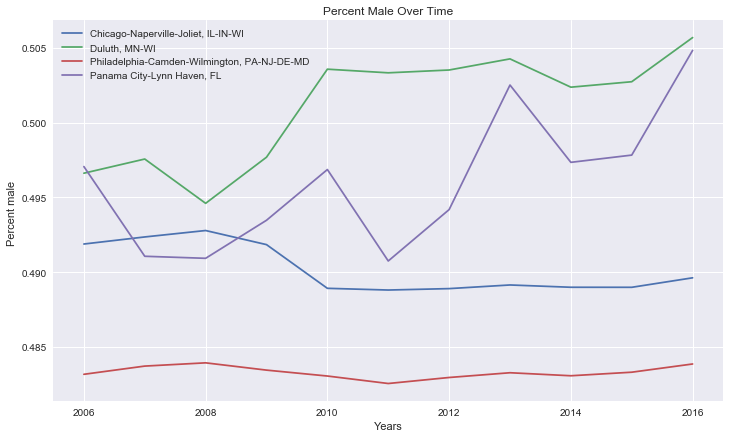

In [32]:
trend_plot('Percent_male_', sub_ids, 'Percent Male Over Time')

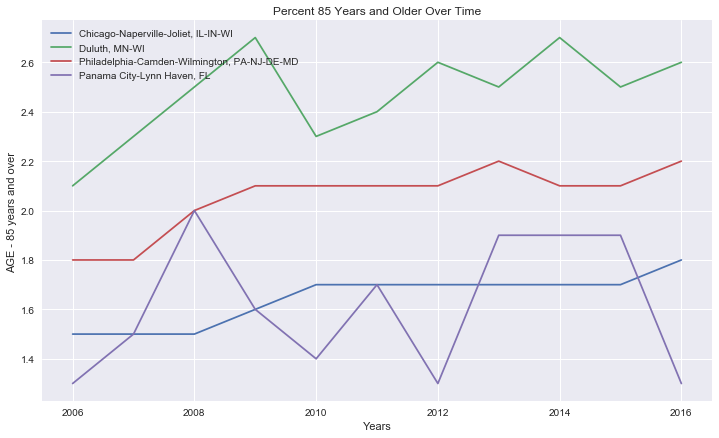

In [33]:
trend_plot('AGE - 85 years and over_', sub_ids, 'Percent 85 Years and Older Over Time')

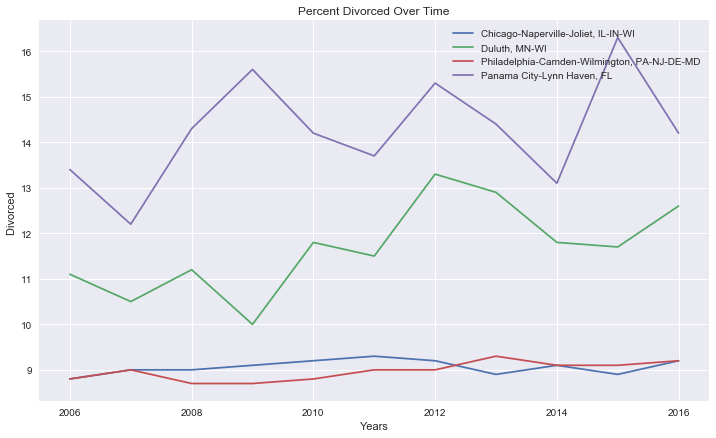

In [34]:
trend_plot('Divorced_', sub_ids, 'Percent Divorced Over Time')

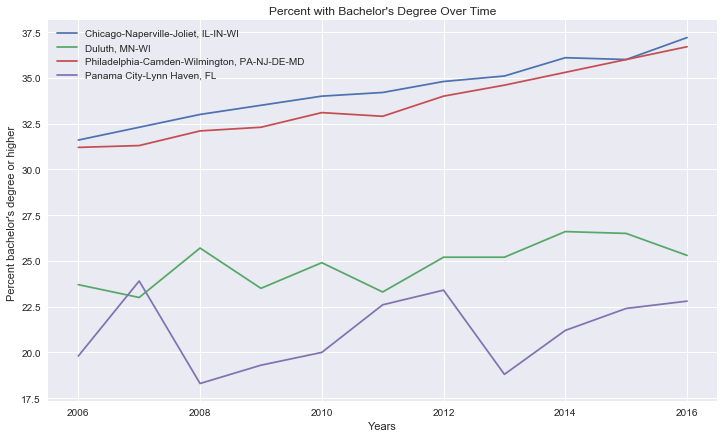

In [35]:
trend_plot("Percent bachelor's degree or higher_", sub_ids, "Percent with Bachelor's Degree Over Time")

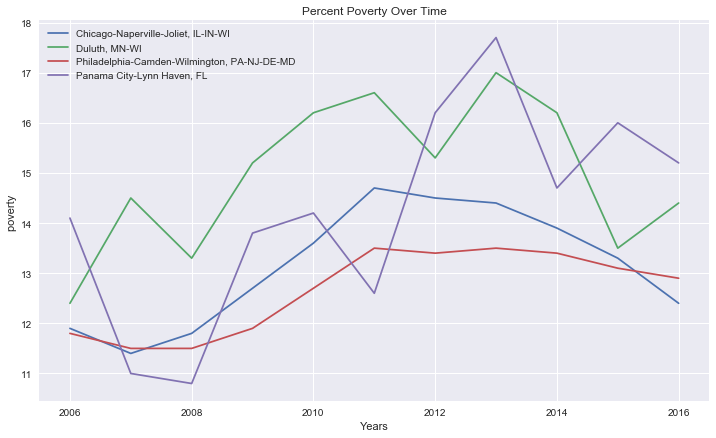

In [36]:
trend_plot('poverty_', sub_ids, 'Percent Poverty Over Time')

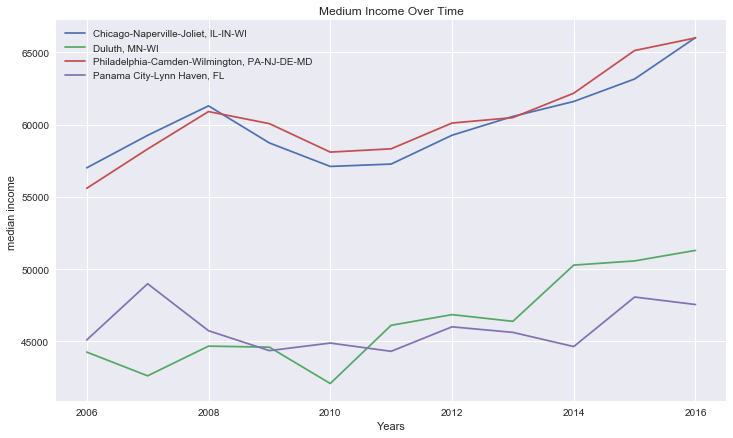

In [37]:
trend_plot('median_income_', sub_ids, 'Medium Income Over Time')

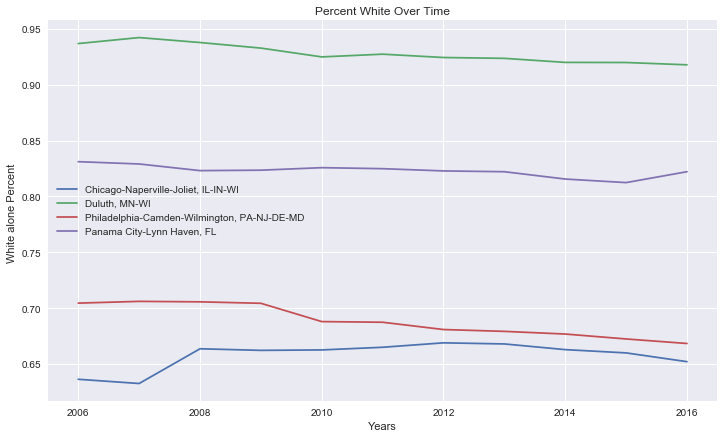

In [38]:
trend_plot('White alone_Percent_', sub_ids, 'Percent White Over Time')

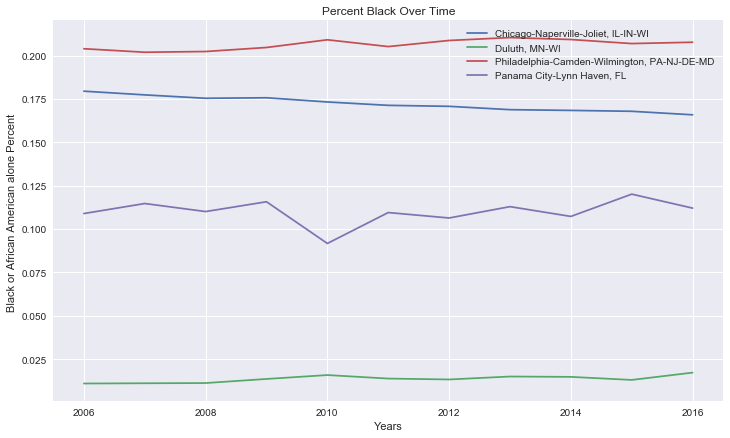

In [39]:
trend_plot('Black or African American alone_Percent_', sub_ids, 'Percent Black Over Time')

### Murder Over Time

In [40]:
sub_years = {}
for i in range(2006,2017):
    sub_years[i] = dict_df_year[i].loc[dict_df_year[i]['ID'].isin(sub_ids)]


In [41]:
sub_years[2008]

pop_08  Percent_male_08  Percent_female_08  AGE - Under 5 years_08  \
78    275336         0.494599           0.505401                     5.5   
215   163946         0.490924           0.509076                     6.6   
218  5838471         0.483937           0.516063                     6.5   

     AGE - 5 to 9 years_08  AGE - 10 to 14 years_08  AGE - 15 to 19 years_08  \
78                     5.7                      5.3                      7.7   
215                    6.9                      6.1                      6.2   
218                    6.4                      6.6                      7.5   

     AGE - 20 to 24 years_08  AGE - 25 to 29 years_08  \
78                       8.4                      6.6   
215                      5.4                      6.8   
218                      6.7                      5.9   

     AGE - 30 to 34 years_08     ...      \
78                       5.4     ...       
215                      6.4     ...       
218                      5.9     ...       

     American Indian and Alaska Native alone_Percent_08  \
78                                            0.026509    
215                                           0.002104    
218                                           0.002305    

     Asian alone_Percent_08  \
78                 0.006505   
215                0.017579   
218                0.043522   

     Native Hawaiian and Other Pacific Islander alone_Percent_08  \
78                                            0.000000             
215                                           0.002049             
218                                           0.000195             

     Some other race alone_Percent_08  Two or more races:_Percent_08  \
78                           0.000701                       0.017161   
215                          0.004264                       0.040751   
218                          0.028367                       0.017605   

                                        msa_name  Murder 2008     ID  \
78                                 Duluth, MN-WI          4.0  20260   
215                   Panama City-Lynn Haven, FL         11.0  37460   
218  Philadelphia-Camden-Wilmington, PA-NJ-DE-MD        530.0  37980   

     murder_category  murder_pop  
78                 0    0.000015  
215                1    0.000067  
218                2    0.000091  

[3 rows x 42 columns]

In [42]:
# looks at sub years and checks whether all ids are there and extracts murders
# if some id's are missing, murders for those are set to zero (e.g. Chicago from 2006 to 2010)
def find_yw_data(sub_years, sub_ids):
    main = []
    for i in range (2006,2017):
        temp = []
        for j in sub_ids:
            if sum((sub_years[i]['ID'])== j) == 1:
#                 print((sub_years[i][sub_years[i]['ID']==j]))
                temp.append(sub_years[i][sub_years[i]['ID'] == j]['Murder '+ str(i)].values)
            else:
                temp.append(0)
        main.append(temp)
    return(main)

In [43]:
# use msa just for the feature trends
# plots murder trends given MSA indices
def murder_trend_plot(sub_ids):
    murder_years = np.array(find_yw_data(sub_years,sub_ids))
    new_cols = msa_df.loc[sub_ids]['msa_name'].tolist()
    x = np.arange(2006,2017,1)
    plt.figure(figsize=(16, 8))
    for i in range(len(sub_ids)):
        plt.plot(x,murder_years[:,i],label = new_cols[i])
    plt.legend(loc='best')
    plt.xlabel('Years')
    plt.ylabel('Murders')
    plt.title('Murder Counts Over Time')

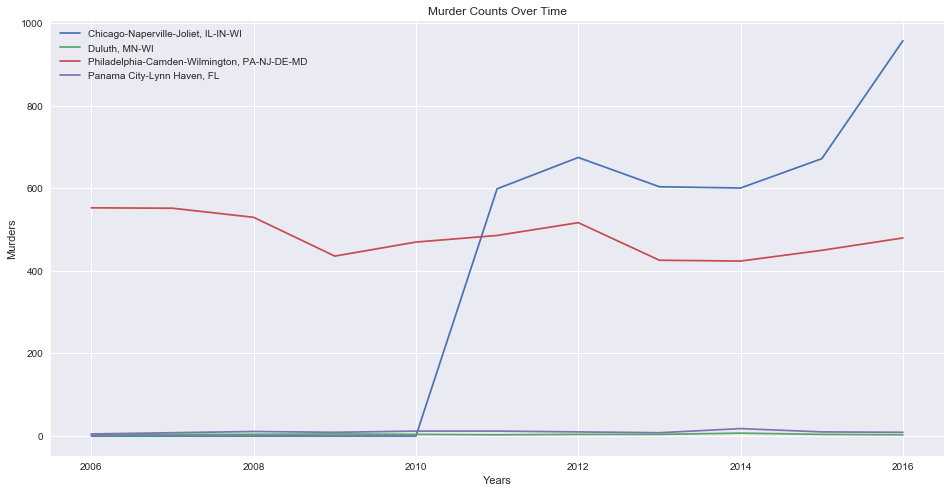

In [44]:
murder_trend_plot(sub_ids)

### Murder by Feature 

In [45]:
# use msa just for the feature trends

# feature trends

# use msa just for the feature trends
# scatter plot of feature against the murder with data from all years

def feature_murder_plot(feature_name, sub_ids, title):
    pc_temp =[]
    sub_years = {}
    for i in range(2006, 2017):
        sub_years[i] = dict_df_year[i].loc[dict_df_year[i]['ID'].isin(sub_ids)]

    for i in range(2006,2017):
        pc_temp.append(msa_df.loc[sub_ids].columns.get_loc(feature_name + '%02d' %(i - 2000)))
    murder_years = np.array(find_yw_data(sub_years, sub_ids))
    # index all rows with interesting sub ids and feature of interest columns
    df_temp = msa_df.loc[sub_ids].iloc[:,pc_temp]
    # add row for years
    df_temp.loc[len(df_temp)] = np.arange(2006, 2017, 1)
    df_temp = df_temp.T
    new_cols = msa_df.loc[sub_ids]['msa_name'].tolist()
    new_cols.append('year')
    df_temp.columns = new_cols 
    plt.figure(figsize=(12, 6))
    for i in range(len(sub_ids)):
        plt.scatter(df_temp.iloc[:,i].values,murder_years[:,i],label = new_cols[i])
    plt.legend(loc='best')
    plt.ylabel('# of Murders')
    plt.xlabel(feature_name.replace("_", " "))
    plt.title(title)
    


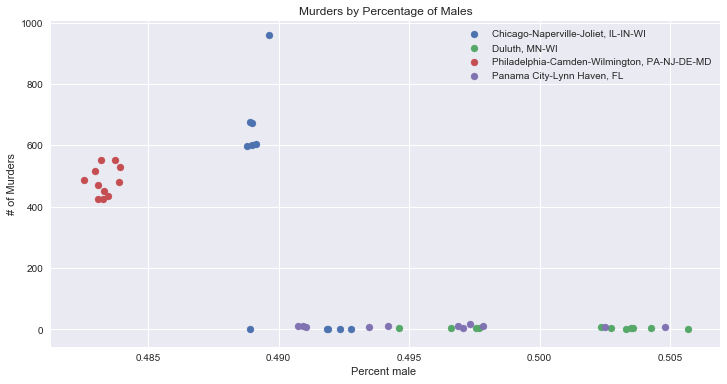

In [46]:
feature_murder_plot('Percent_male_', sub_ids, 'Murders by Percentage of Males')

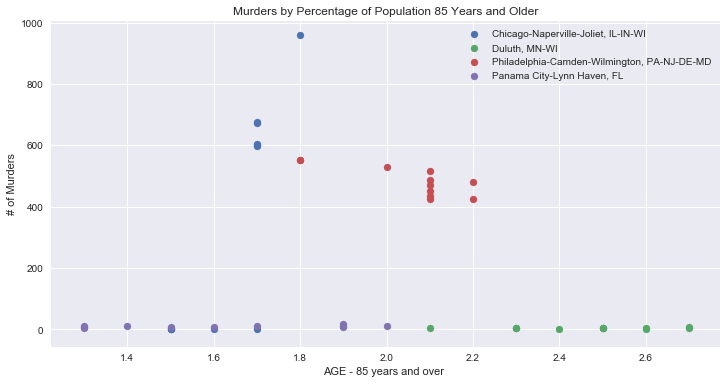

In [47]:
feature_murder_plot('AGE - 85 years and over_', sub_ids, 'Murders by Percentage of Population 85 Years and Older')

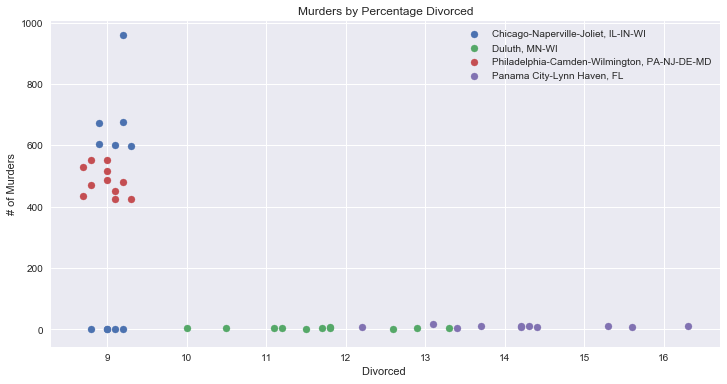

In [48]:
feature_murder_plot('Divorced_', sub_ids, 'Murders by Percentage Divorced')

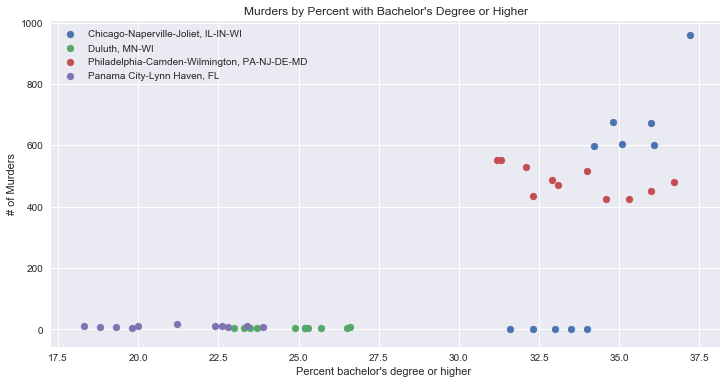

In [49]:
feature_murder_plot("Percent bachelor's degree or higher_", sub_ids, "Murders by Percent with Bachelor's Degree or Higher")

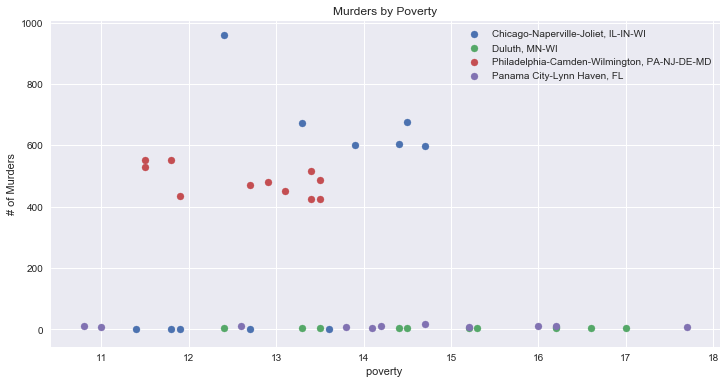

In [50]:
feature_murder_plot('poverty_', sub_ids, 'Murders by Poverty')

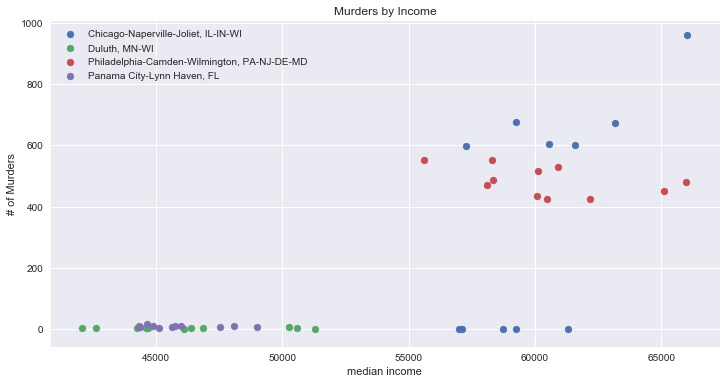

In [51]:
feature_murder_plot('median_income_', sub_ids, 'Murders by Income')

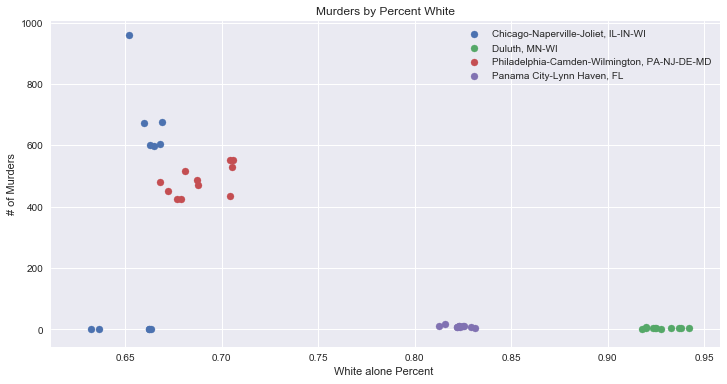

In [52]:
feature_murder_plot('White alone_Percent_', sub_ids, 'Murders by Percent White')

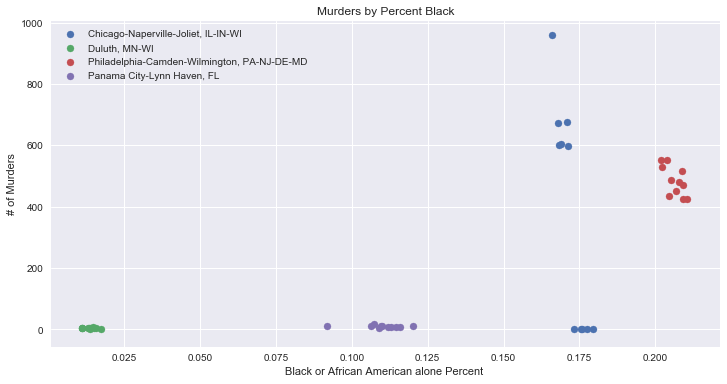

In [53]:
feature_murder_plot('Black or African American alone_Percent_', sub_ids, 'Murders by Percent Black')

****

### Murder on Map of US

We use Geopy to find the longitude and latitiude of each MSA and plot them on a map`

In [55]:
import math
## find lat and long for each msa
geolocator = Nominatim()
# lat_long = []
# for row in unique_id['msa_name']:
#     if geolocator.geocode(row) == None:
#         lat_long.append(np.nan)
#     if geolocator.geocode(row) != None:
#         lat_long.append(geolocator.geocode(row)[1])
   

    
# # save as file
# with open('outfile', 'wb') as fp:
#     pickle.dump(lat_long, fp)
    
    
# read in file
with open ('outfile', 'rb') as fp:
    llng = pickle.load(fp)

# split by latitude and longitude 
lat = []
long = []
for i in llng:
    if type(i) is float:
        lat.append(np.nan)
        long.append(np.nan)
    if type(i) is tuple:
        lat.append(i[0])
        long.append(i[1])

lat_long_df = pd.DataFrame([unique_id['ID'].tolist(), lat, long]).T

lat_long_df.columns = ['ID', 'latitude', 'longitude']
lat_long_df.loc[lat_long_df['ID'] == 12540, 'latitude'] = geolocator.geocode('Bakersfield, CA')[1][0]
lat_long_df.loc[lat_long_df['ID'] == 12540, 'longitude'] = geolocator.geocode('Bakersfield, CA')[1][1]
lat_long_df.loc[lat_long_df['ID'] == 42340, 'latitude'] = geolocator.geocode('Savannah, GA')[1][0]
lat_long_df.loc[lat_long_df['ID'] == 42340, 'longitude'] = geolocator.geocode('Savannah, GA')[1][1]
lat_long_df.loc[lat_long_df['ID'] == 36740, 'latitude'] = geolocator.geocode('Orlando, FL')[1][0]
lat_long_df.loc[lat_long_df['ID'] == 36740, 'longitude'] = geolocator.geocode('Orlando, FL')[1][1]
lat_long_df.loc[lat_long_df['ID'] == 22900, 'latitude'] = geolocator.geocode('Fort Smith, AR-OK')[1][0]
lat_long_df.loc[lat_long_df['ID'] == 22900, 'longitude'] = geolocator.geocode('Fort Smith, AR-OK')[1][1]
lat_long_df.loc[lat_long_df['ID'] == 33340, 'latitude'] = geolocator.geocode('Milwaukee, WI')[1][0]
lat_long_df.loc[lat_long_df['ID'] == 33340, 'longitude'] = geolocator.geocode('Milwaukee, WI')[1][1]
lat_long_df.loc[lat_long_df['ID'] == 20020, 'latitude'] = geolocator.geocode('Dothan, AL')[1][0]
lat_long_df.loc[lat_long_df['ID'] == 20020, 'longitude'] = geolocator.geocode('Dothan, AL')[1][1]
lat_long_df.loc[lat_long_df['ID'] == 23540, 'latitude'] = geolocator.geocode('Gainesville, FL')[1][0]
lat_long_df.loc[lat_long_df['ID'] == 23540, 'longitude'] = geolocator.geocode('Gainesville, FL')[1][1]
lat_long_df.loc[lat_long_df['ID'] == 19820, 'latitude'] = geolocator.geocode('Detroit, MI')[1][0]
lat_long_df.loc[lat_long_df['ID'] == 19820, 'longitude'] = geolocator.geocode('Detroit, MI')[1][1]
lat_long_df.loc[lat_long_df['ID'] == 11180, 'latitude'] = geolocator.geocode('Ames, IA')[1][0]
lat_long_df.loc[lat_long_df['ID'] == 11180, 'longitude'] = geolocator.geocode('Ames, IA')[1][1]
lat_long_df.loc[lat_long_df['ID'] == 29020, 'latitude'] = geolocator.geocode('Kokomo, IN')[1][0]
lat_long_df.loc[lat_long_df['ID'] == 29020, 'longitude'] = geolocator.geocode('Kokomo, IN')[1][1]
lat_long_df.loc[lat_long_df['ID'] == 41660, 'latitude'] = geolocator.geocode('San Angelo, TX')[1][0]
lat_long_df.loc[lat_long_df['ID'] == 41660, 'longitude'] = geolocator.geocode('San Angelo, TX')[1][1]
lat_long_df.loc[lat_long_df['ID'] == 38940, 'latitude'] = geolocator.geocode('Port St. Lucie, FL')[1][0]
lat_long_df.loc[lat_long_df['ID'] == 38940, 'longitude'] = geolocator.geocode('Port St. Lucie, FL')[1][1]
lat_long_df.loc[lat_long_df['ID'] == 42060, 'latitude'] = geolocator.geocode('Santa Barbara, CA')[1][0]
lat_long_df.loc[lat_long_df['ID'] == 42060, 'longitude'] = geolocator.geocode('Santa Barbara, CA')[1][1]
lat_long_df.loc[lat_long_df['ID'] == 12620, 'latitude'] = geolocator.geocode('Bangor, Maine')[1][0]
lat_long_df.loc[lat_long_df['ID'] == 12620, 'longitude'] = geolocator.geocode('Bangor, Maine')[1][1]
lat_long_df.loc[lat_long_df['ID'] == 44700, 'latitude'] = geolocator.geocode('Stockton, California')[1][0]
lat_long_df.loc[lat_long_df['ID'] == 44700, 'longitude'] = geolocator.geocode('Stockton, California')[1][1]




GeocoderTimedOut: Service timed out

In [56]:
# add to each df
position_murder_df = {}
for i in range(2006, 2017):
    position_murder_df[i] = dict_df_year[i].merge(lat_long_df, left_on = 'ID', right_on = 'ID', how = 'inner')


In [57]:
position_murder_df[2006][position_murder_df[2006]['Murder 2006'] == 57]



pop_06  Percent_male_06  Percent_female_06  AGE - Under 5 years_06  \
286  673170         0.501191           0.498809                     8.0   

     AGE - 5 to 9 years_06  AGE - 10 to 14 years_06  AGE - 15 to 19 years_06  \
286                    7.7                      8.0                      8.4   

     AGE - 20 to 24 years_06  AGE - 25 to 29 years_06  \
286                      7.4                      8.2   

     AGE - 30 to 34 years_06    ...      \
286                      7.1    ...       

     Native Hawaiian and Other Pacific Islander alone_Percent_06  \
286                                           0.004526             

     Some other race alone_Percent_06  Two or more races:_Percent_06  \
286                          0.110997                       0.043491   

         msa_name  Murder 2006     ID  murder_category  murder_pop   latitude  \
286  Stockton, CA         57.0  44700                2    0.000085  49.583333   

     longitude  
286     -99.45  

[1 rows x 44 columns]

In [58]:
import plotly.plotly as py
import pandas as pd

import plotly 
plotly.tools.set_credentials_file(username ='jeanettejin', api_key ='65684eh97DVINyUzjc0P')

data = [dict(
    lat = position_murder_df[2006]['latitude'],
    lon = position_murder_df[2006]['longitude'],
    text =  position_murder_df[2006]['Murder 2006'].astype(str) + ' count',

    marker = dict(
        size = 6,
        color = position_murder_df[2006]['Murder 2006'],
        colorsrc = "jeanettejin:2:236ccc",
        opacity = 1.0,
        colorscale =  [[0, 'rgb(49,54,149)'], [1./10000, 'rgb(69,117,180)'], [1./1000, 'rgb(116,173,209)'], [1./100, 'rgb(254,224,144)'], [1./10, 'rgb(253,174,97)'], [1./1, 'rgb(244,109,67)']],
        colorbar = dict(
            thickness = 10,
            titleside = "right",
            outlinecolor = "rgba(68, 68, 68, 0)",
#             tickmode = 'auto',
            ticklen = 3,
            showticksuffix = 'first',
            ticksuffix = " count",
#             showticklabels = True,
        ),
    ),
    type = 'scattergeo',
  

) ]

    

layout = dict(
    geo = dict(
        scope = 'north america',
        showland = True,
        landcolor = "rgb(212, 212, 212)",
        subunitcolor = "rgb(255, 255, 255)",
        countrycolor = "rgb(255, 255, 255)",
        showlakes = True,
        lakecolor = "rgb(255, 255, 255)",
        showsubunits = True,
        showcountries = True,
        resolution = 50,
        projection = dict(
            type = 'conic conformal',
            rotation = dict(
                lon = -100
            )
        ),
        lonaxis = dict(
            showgrid = True,
            gridwidth = 0.5,
            range= [ -140.0, -55.0 ],
            dtick = 5
        ),
        lataxis = dict (
            showgrid = True,
            gridwidth = 0.5,
            range= [ 20.0, 60.0 ],
            dtick = 5
        )
    ),
    title = 'Murder Counts in US 2006',
)
fig = {'data': data, 'layout': layout }
py.iplot(fig, filename = 'Murder_2006')

In [59]:
import plotly.plotly as py
import pandas as pd

import plotly 
plotly.tools.set_credentials_file(username ='jeanettejin', api_key ='65684eh97DVINyUzjc0P')

data = [dict(
    lat = position_murder_df[2016]['latitude'],
    lon = position_murder_df[2016]['longitude'],
    text =  position_murder_df[2016]['Murder 2016'].astype(str) + ' count',

    marker = dict(
        size = 6,
        color =  position_murder_df[2016]['Murder 2016'],
        colorsrc = "jeanettejin:2:236ccc",
        opacity = 1,
        colorscale =  [[0, 'rgb(49,54,149)'], [1./10000, 'rgb(69,117,180)'], [1./1000, 'rgb(116,173,209)'], [1./100, 'rgb(254,224,144)'], [1./10, 'rgb(253,174,97)'], [1./1, 'rgb(244,109,67)']],
        colorbar = dict(
            thickness = 10,
            titleside = "right",
            outlinecolor = "rgba(68, 68, 68, 0)",
            tickmode = 'auto',
            ticklen = 3,
            showticksuffix = 'first',
            ticksuffix = " count",
            showticklabels = True,
        ),
    ),
    type = 'scattergeo',
  

) ]
  
layout = dict(
    geo = dict(
        scope = 'north america',
        showland = True,
        landcolor = "rgb(212, 212, 212)",
        subunitcolor = "rgb(255, 255, 255)",
        countrycolor = "rgb(255, 255, 255)",
        showlakes = True,
        lakecolor = "rgb(255, 255, 255)",
        showsubunits = True,
        showcountries = True,
        resolution = 50,
        projection = dict(
            type = 'conic conformal',
            rotation = dict(
                lon = -100
            )
        ),
        lonaxis = dict(
            showgrid = True,
            gridwidth = 0.5,
            range= [ -140.0, -55.0 ],
            dtick = 5
        ),
        lataxis = dict (
            showgrid = True,
            gridwidth = 0.5,
            range= [ 20.0, 60.0 ],
            dtick = 5
        )
    ),
    title = 'Murder Counts in US 2016',
)
fig = {'data': data, 'layout': layout }
py.iplot(fig, filename = 'Murder_2016')

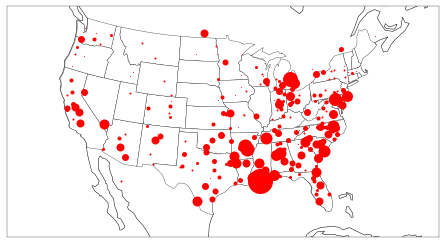

In [60]:
# define the axes and projection type
ax = plt.axes([0, 0, 1, 1],projection=ccrs.LambertConformal())
ax.set_extent([-125, -66.5, 20, 50], ccrs.Geodetic())
shapename = 'admin_1_states_provinces_lakes_shp'
states_shp = shpreader.natural_earth(resolution ='110m', category = 'cultural', name = shapename)

# set what we want to see in the plot (MAP FEATURES)
ax.coastlines(linewidth = 0.5, color = 'black')

for state in shpreader.Reader(states_shp).geometries():
        facecolor = [0.9375, 0.9375, 0.859375]
        edgecolor = 'black'

        ax.add_geometries([state], ccrs.PlateCarree(),facecolor = 'w', edgecolor = edgecolor)


# locations
x, y, z = position_murder_df[2006]['latitude'], position_murder_df[2006]['longitude'], position_murder_df[2006]['murder_pop']

for i in range(len(x.values)):
    plt.plot(y.values[i], x.values[i], marker = 'o', color = 'Red', markersize = int(100000 * z.values[i]), transform = ccrs.Geodetic())

plt.show()

### Histograms of Murders Across Years

We can see that most MSA have pretty low murder counts

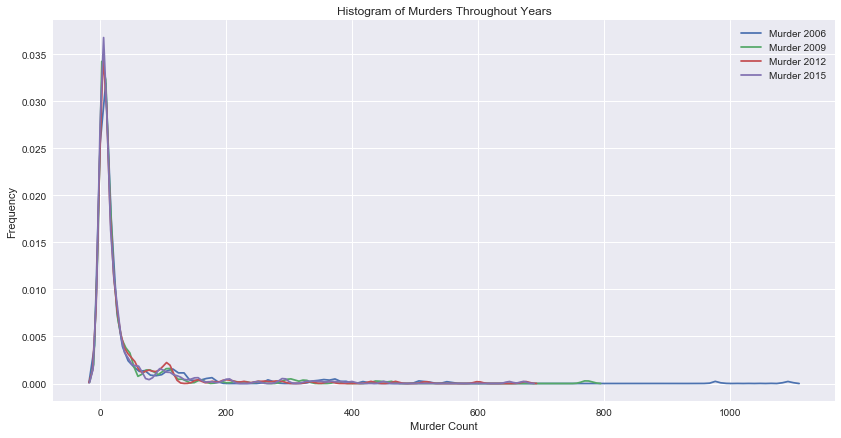

In [61]:
fig, ax = plt.subplots(figsize=(14, 7))
ax.set(xlabel = 'Murder Count', ylabel = 'Frequency')
ax.set_title("Histogram of Murders Throughout Years")


for i in range(2006, 2017, 3):
    sns.kdeplot(dict_df_year[i]['Murder ' + str(i)], ax = ax)
   



### Feature vs Murder or Murder / Population by Group Through TIme

We define a function that plots murder's by feature in certain circumstances, plotted throughout various years. If option is 0 we plot murder by feature for various years. If option is 1, we plot murder by feature and differerentiate each point by weather it's murder_category is low, medium, or high across multiple years. If option is 2, we plot murder divided by population by feature across multiple years. 

In [62]:
def feature_x_time(title, feature, option = 0):

    if option is 0: 
        fig, ax = plt.subplots(1, 4, figsize=(20, 10))
        plt.subplots_adjust(top = .94)
        fig.suptitle(title)
        for i in range(2006, 2017, 3):
            ind = int((i - 2006) / 3)
            sns.regplot(feature + '%02d' % (i - 2000), 'Murder ' + str(i), dict_df_year[i], ax = ax[ind])
            sns.set(font_scale = .7)

    if option is 1:
        for i in range(2006, 2017, 3):
            ind = int((i - 2006) / 3)
            sns.lmplot(feature + '%02d' % (i - 2000), 'Murder ' + str(i), hue = "murder_category", data = dict_df_year[i], size = 6)
    
    if option is 2: 
        fig, ax = plt.subplots(1, 4, figsize=(20, 10))
        plt.subplots_adjust(top = .94)
        fig.suptitle(title)

        for i in range(2006, 2017, 3):
            ind = int((i - 2006) / 3)
            sns.regplot(feature + '%02d' % (i - 2000), 'murder_pop', dict_df_year[i], ax = ax[ind])
            ax[ind].set(ylim=(0.0000, .0001))



We can see that murder and population seem to have a strong linear relationship. For the remainder of the variables, we also include option 2, so we can see how each feature varies with murder/population

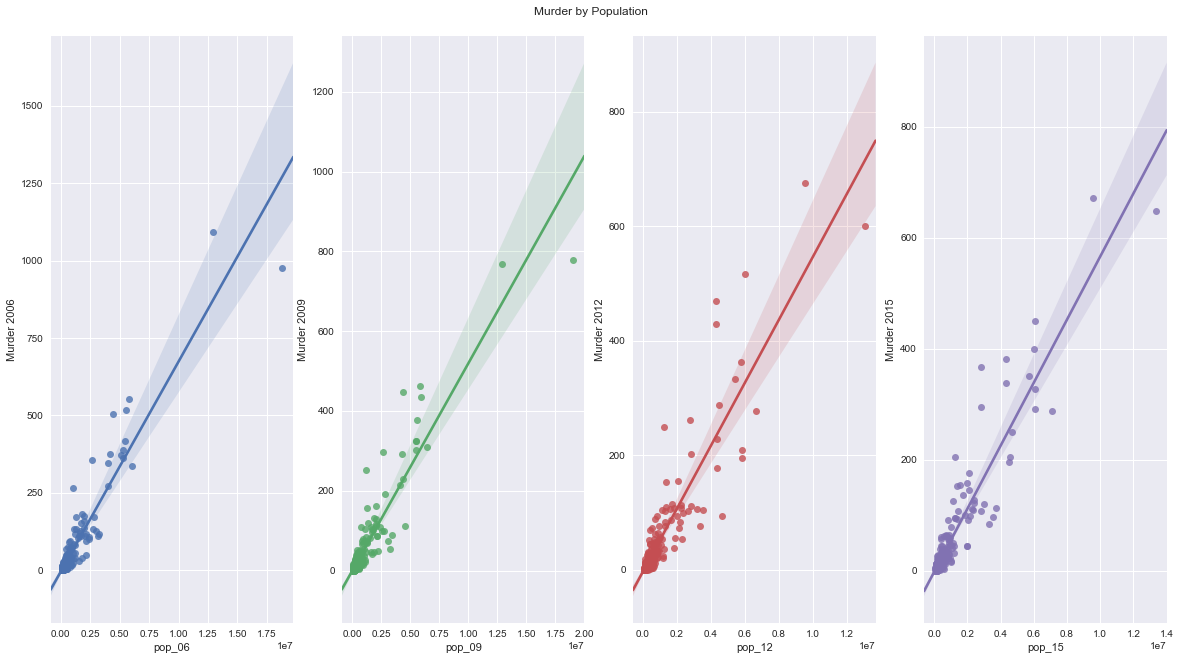

In [63]:
feature_x_time("Murder by Population", 'pop_')

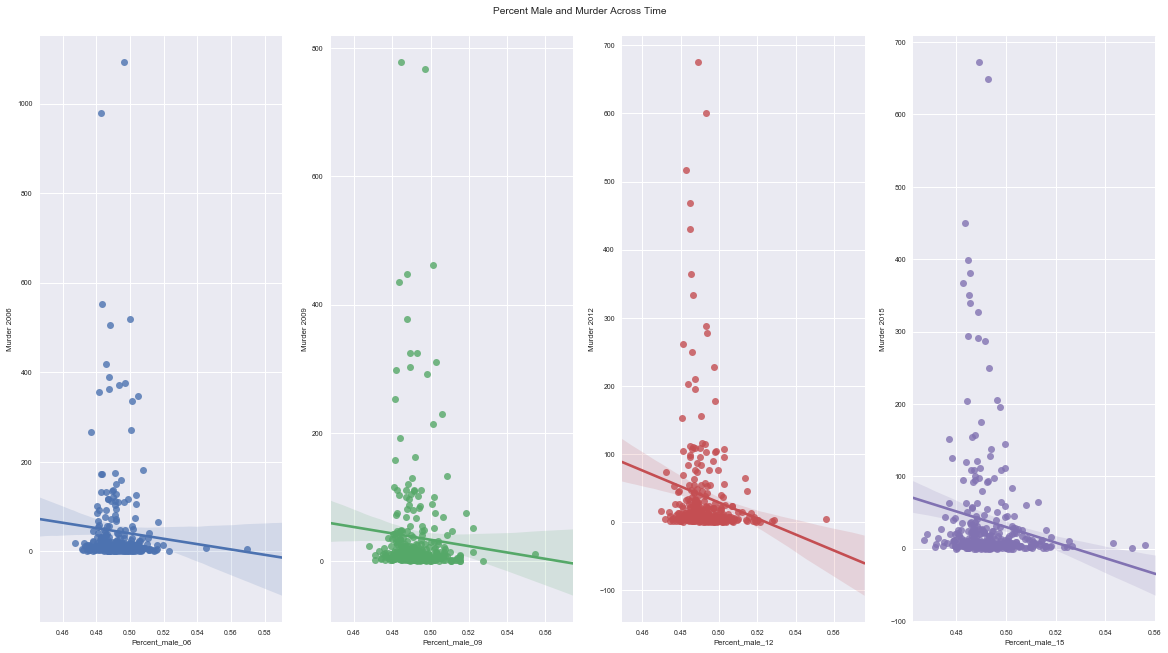

In [64]:
feature_x_time("Percent Male and Murder Across Time", 'Percent_male_')

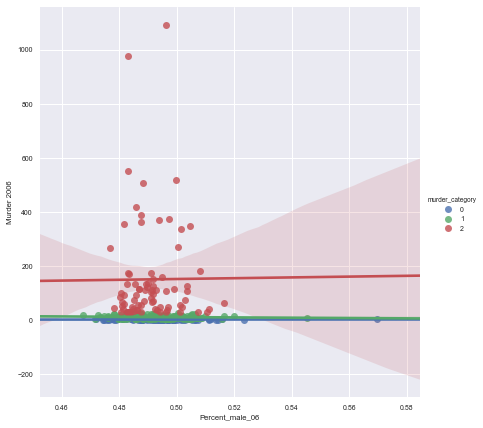

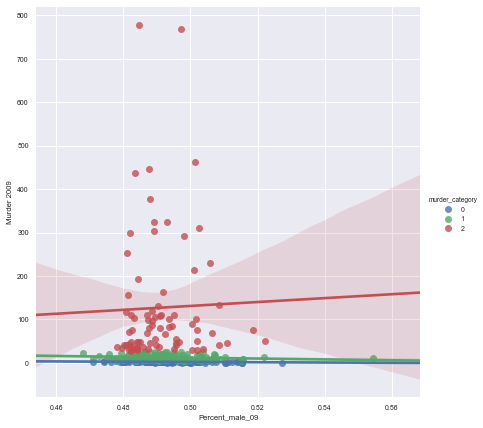

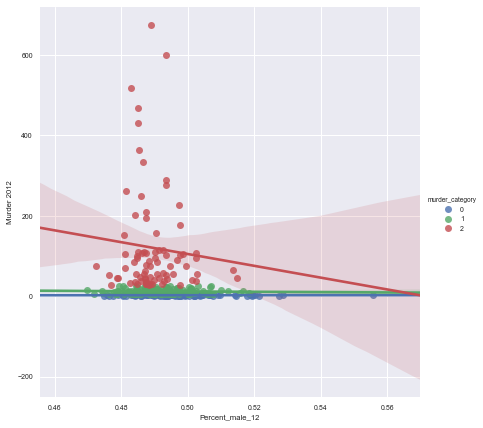

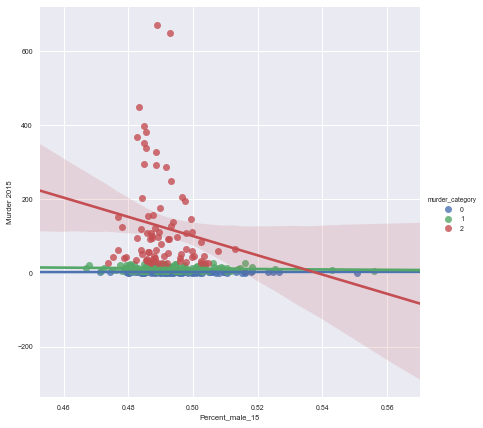

In [65]:
feature_x_time("Percent Male and Murder Across Time", 'Percent_male_', option = 1)

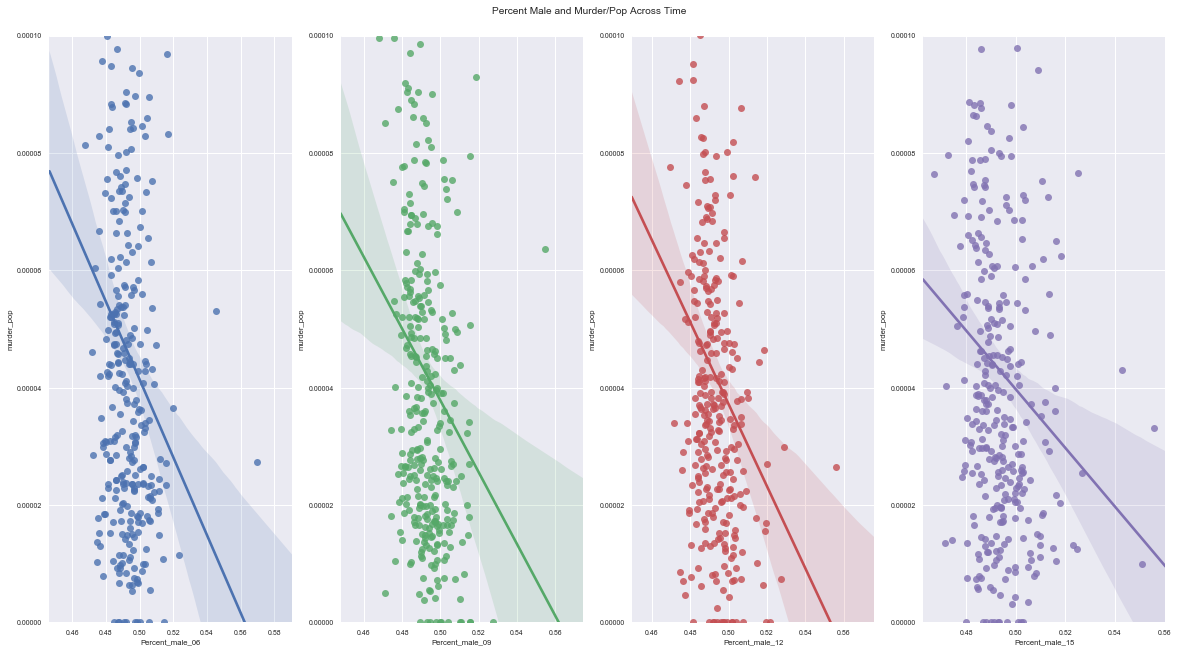

In [66]:
feature_x_time("Percent Male and Murder/Pop Across Time", 'Percent_male_', option = 2)

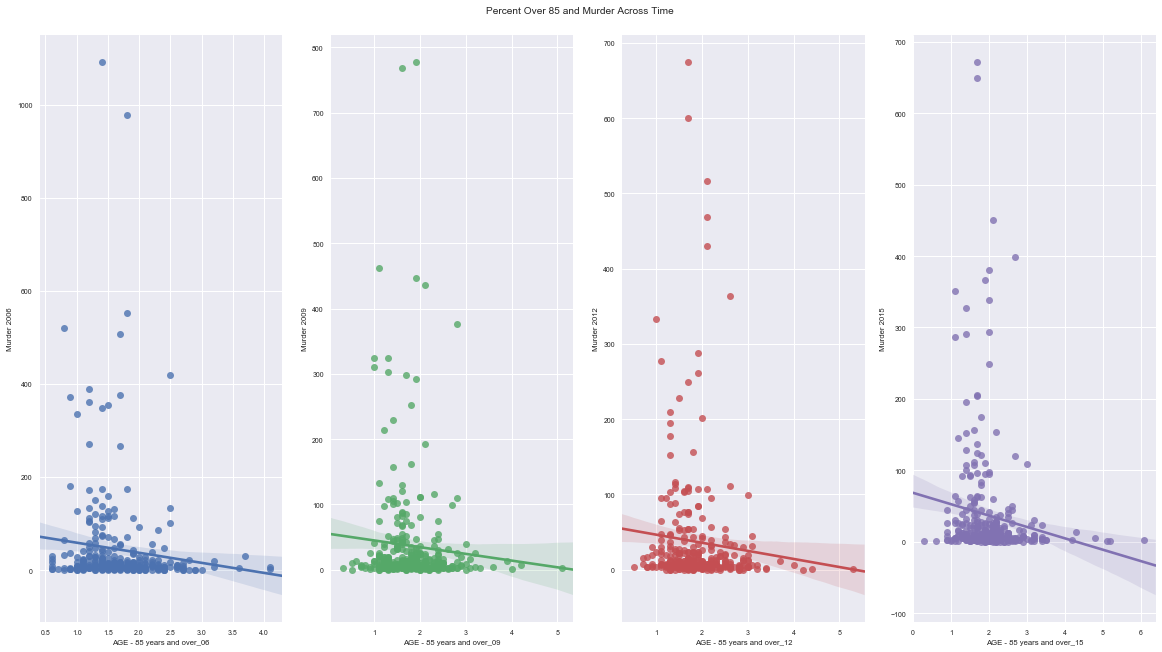

In [67]:
feature_x_time('Percent Over 85 and Murder Across Time', 'AGE - 85 years and over_')


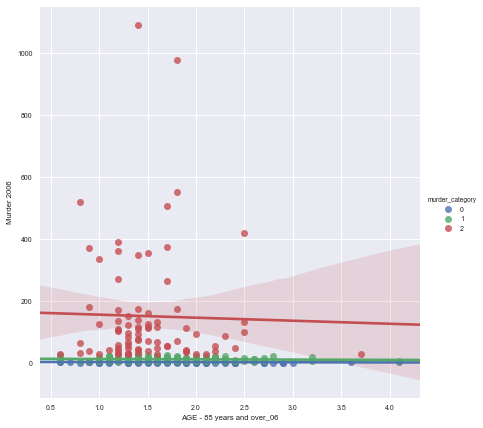

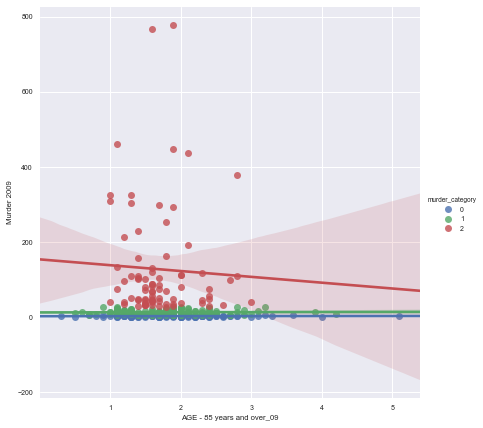

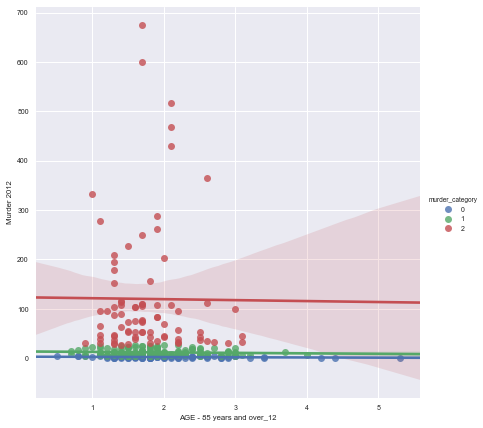

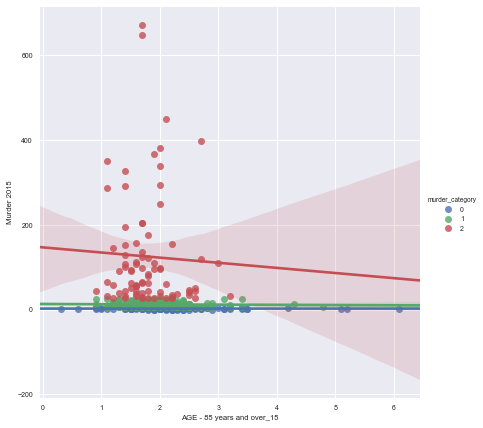

In [68]:
feature_x_time('Percent Over 85 and Murder Across Time', 'AGE - 85 years and over_', option = 1)

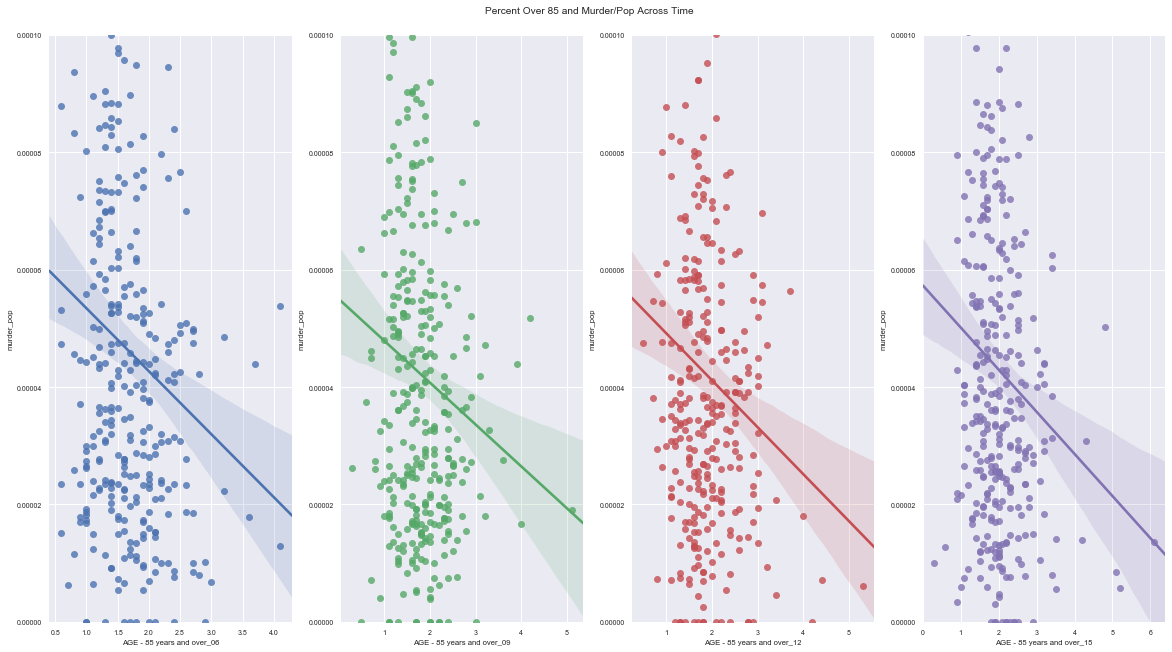

In [69]:
feature_x_time('Percent Over 85 and Murder/Pop Across Time', 'AGE - 85 years and over_', option = 2)

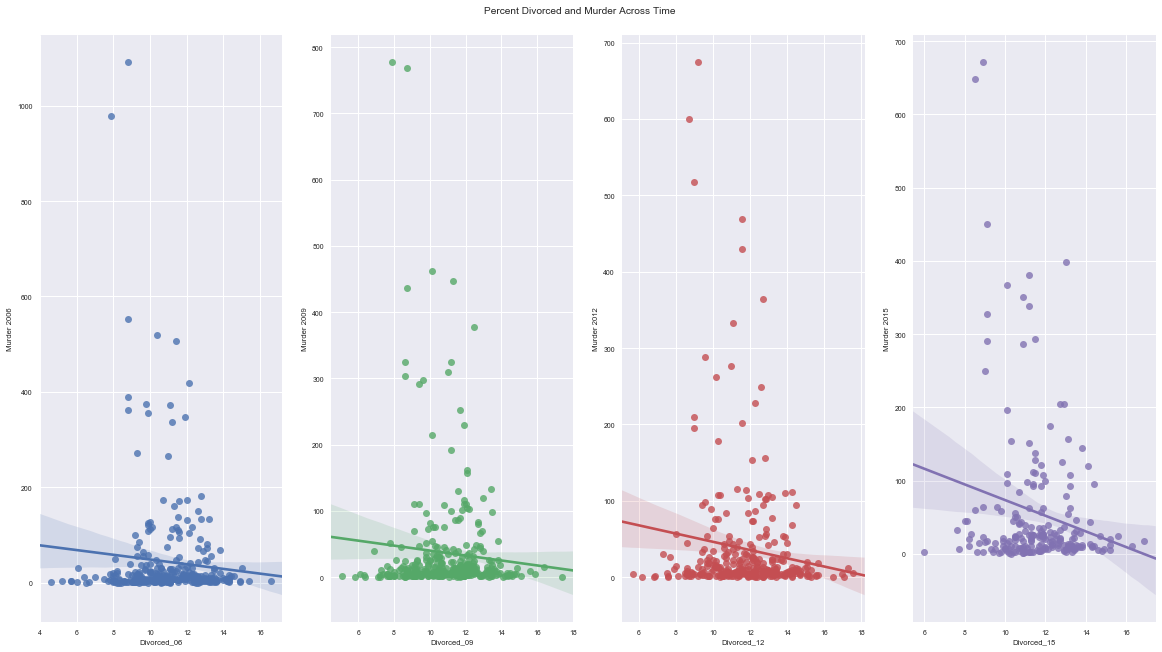

In [70]:
feature_x_time("Percent Divorced and Murder Across Time", "Divorced_")


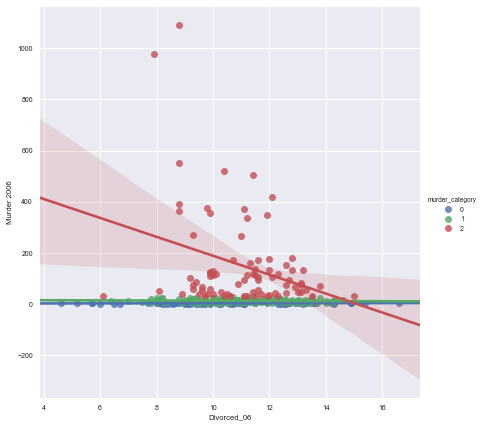

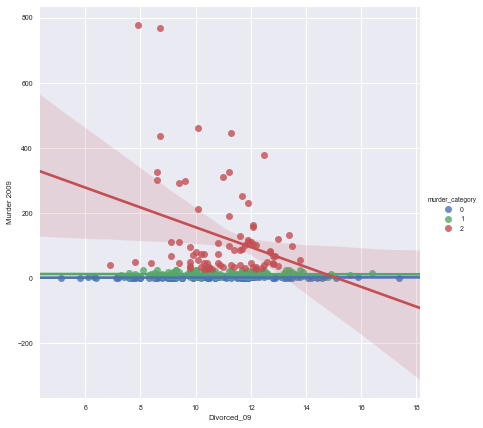

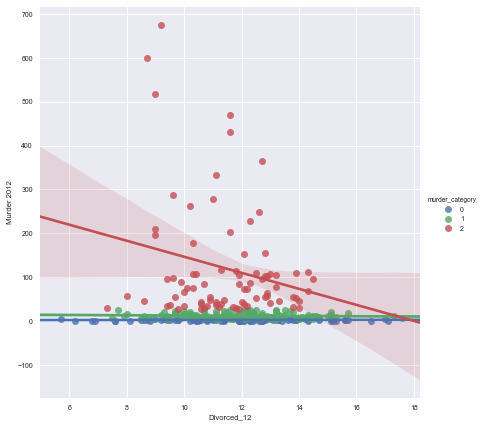

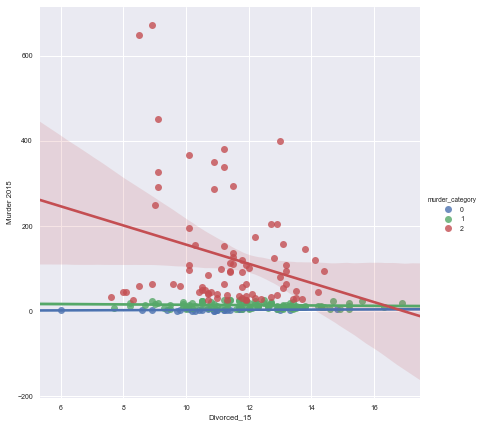

In [71]:
feature_x_time("Percent Divorced and Murder Across Time", "Divorced_", option = 1)

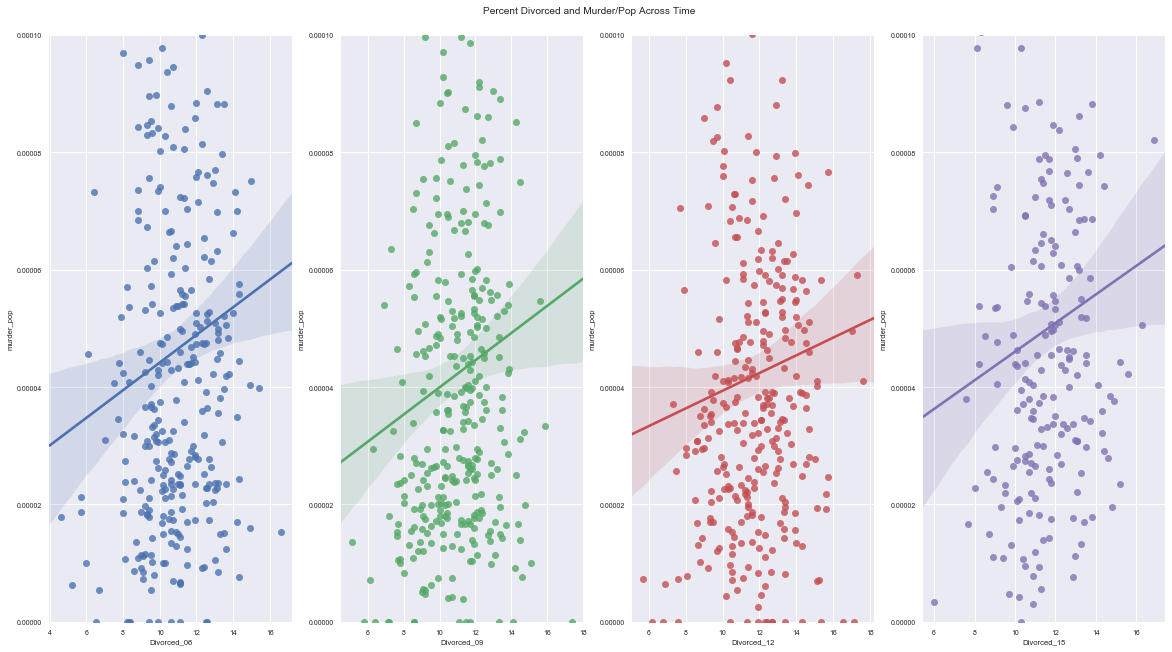

In [72]:
feature_x_time("Percent Divorced and Murder/Pop Across Time", "Divorced_", option = 2)

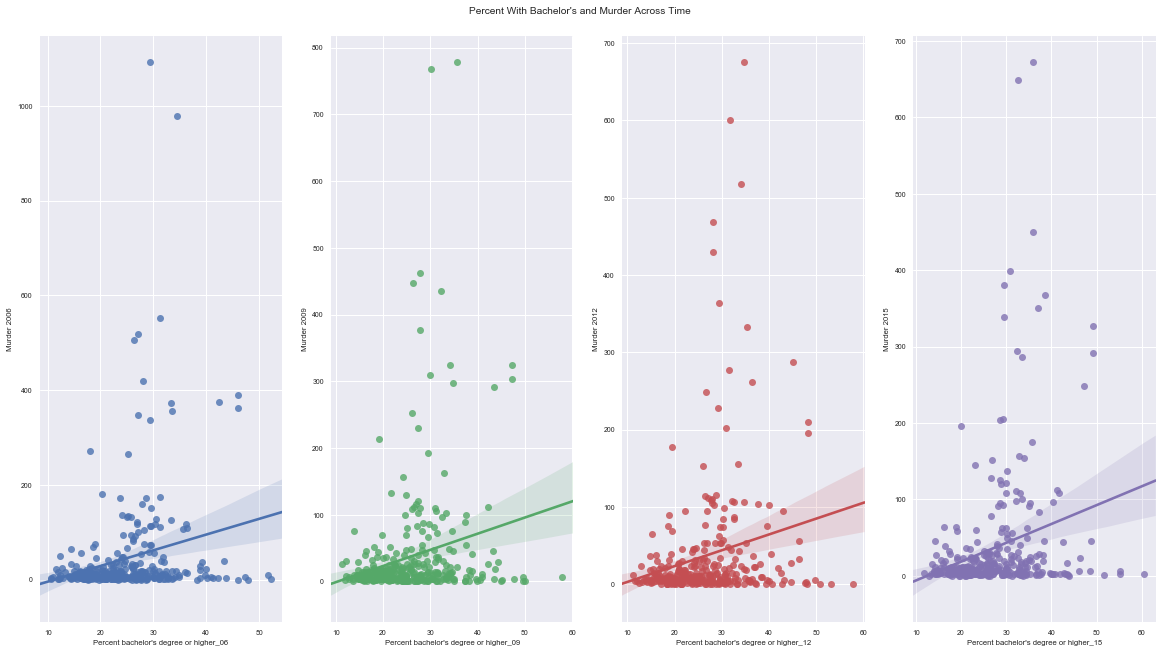

In [73]:
feature_x_time("Percent With Bachelor's and Murder Across Time", "Percent bachelor's degree or higher_")



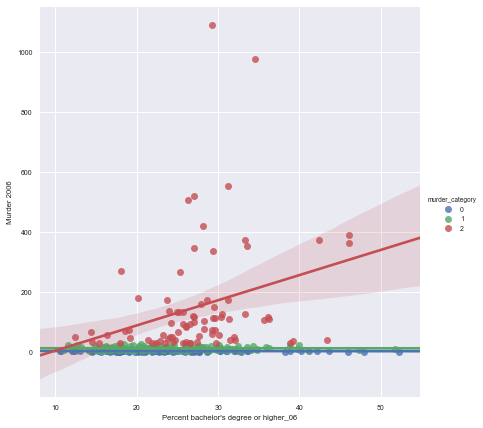

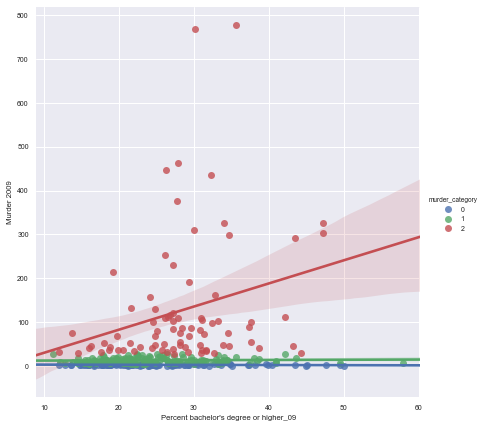

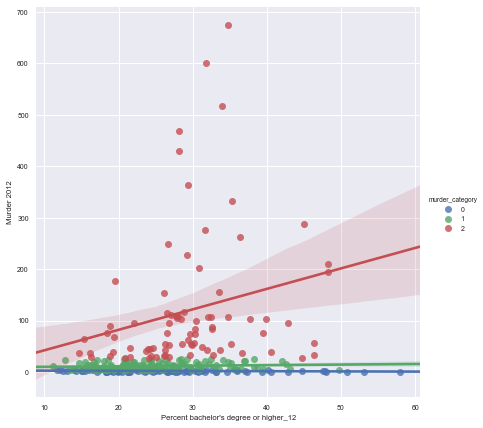

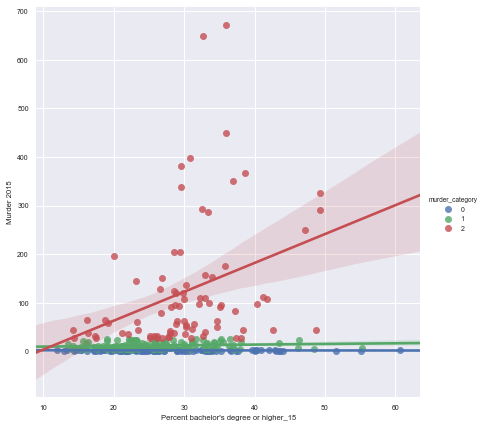

In [74]:
feature_x_time("Percent With Bachelor's and Murder Across Time", "Percent bachelor's degree or higher_", option = 1)


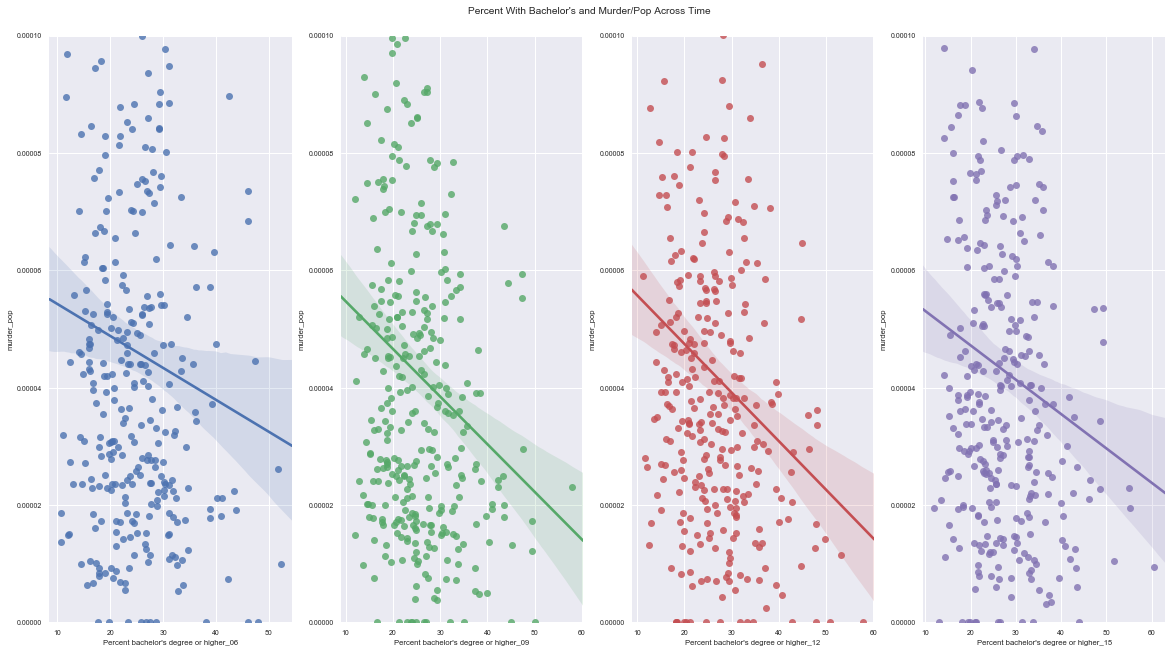

In [75]:
feature_x_time("Percent With Bachelor's and Murder/Pop Across Time", "Percent bachelor's degree or higher_", option = 2)


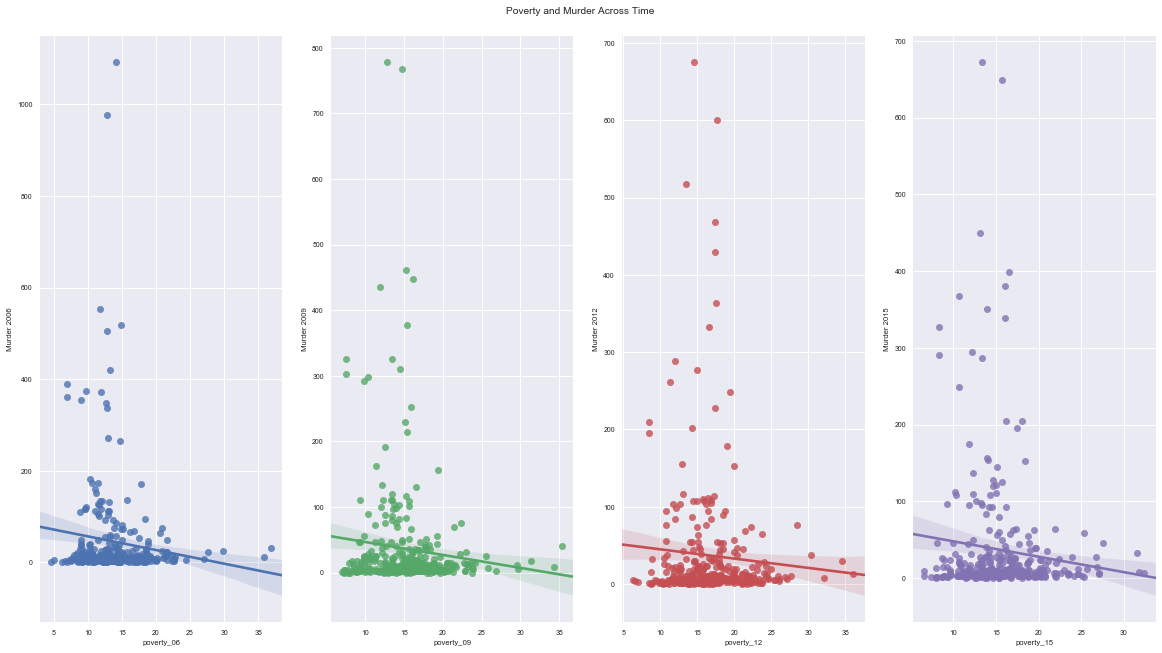

In [76]:
feature_x_time('Poverty and Murder Across Time', 'poverty_')

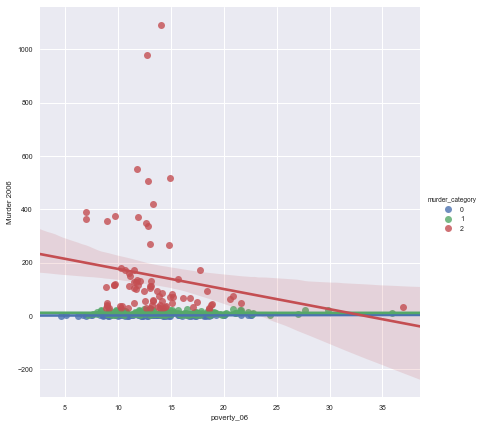

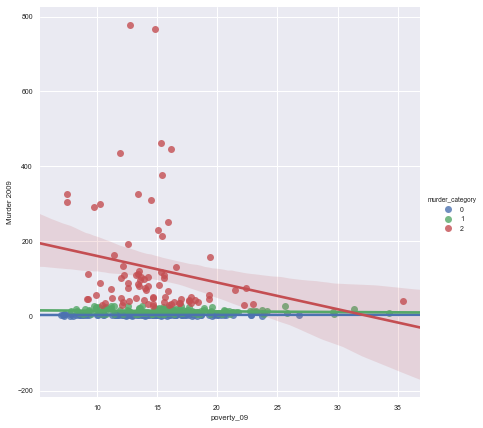

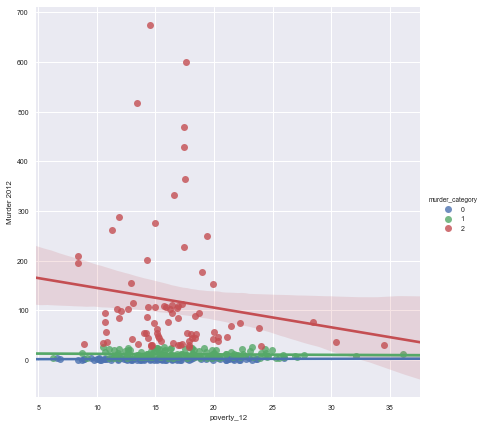

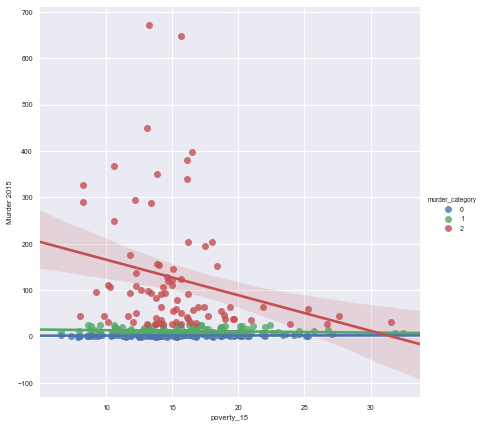

In [77]:
feature_x_time('Poverty and Murder Across Time', 'poverty_', option = 1)

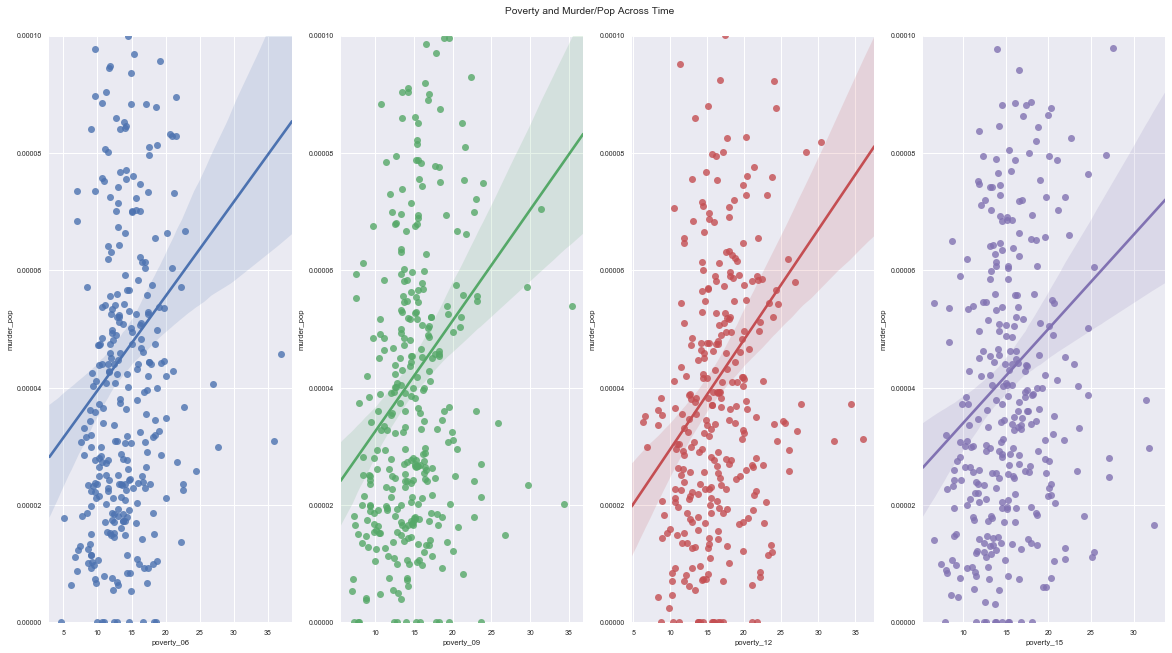

In [78]:
feature_x_time('Poverty and Murder/Pop Across Time', 'poverty_', option = 2)

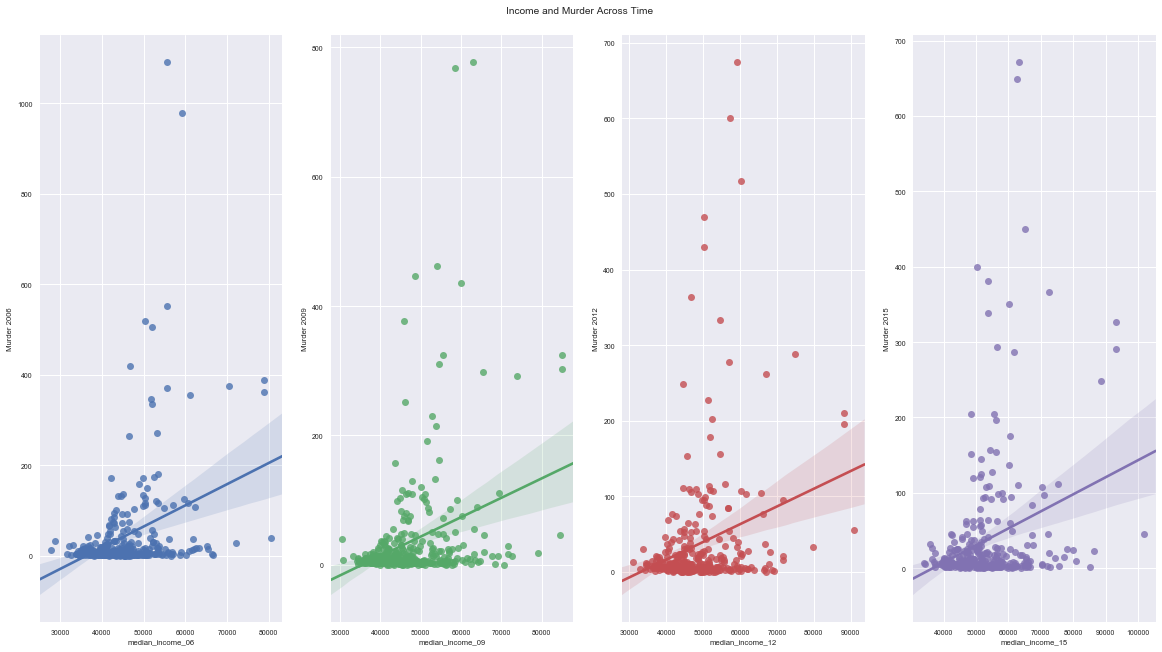

In [79]:
feature_x_time('Income and Murder Across Time', 'median_income_')

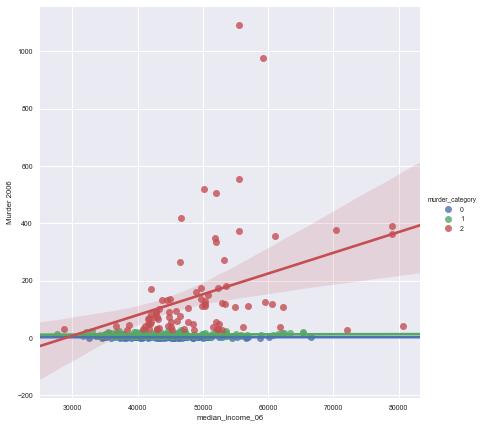

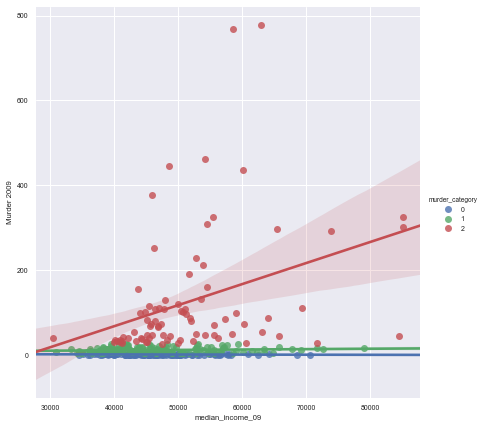

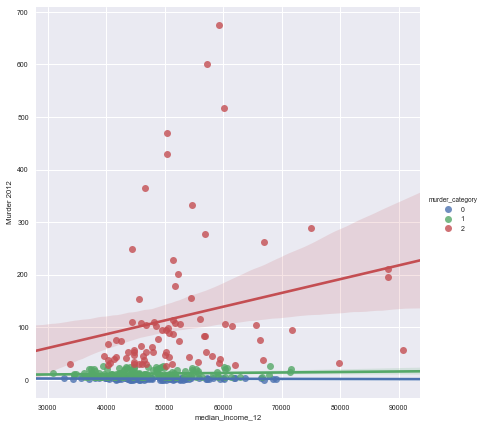

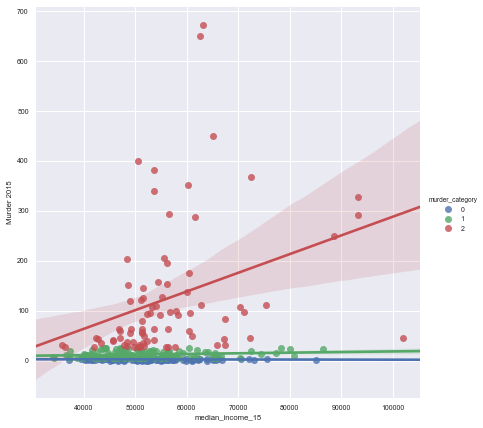

In [80]:
feature_x_time('Income and Murder Across Time', 'median_income_', option = 1)

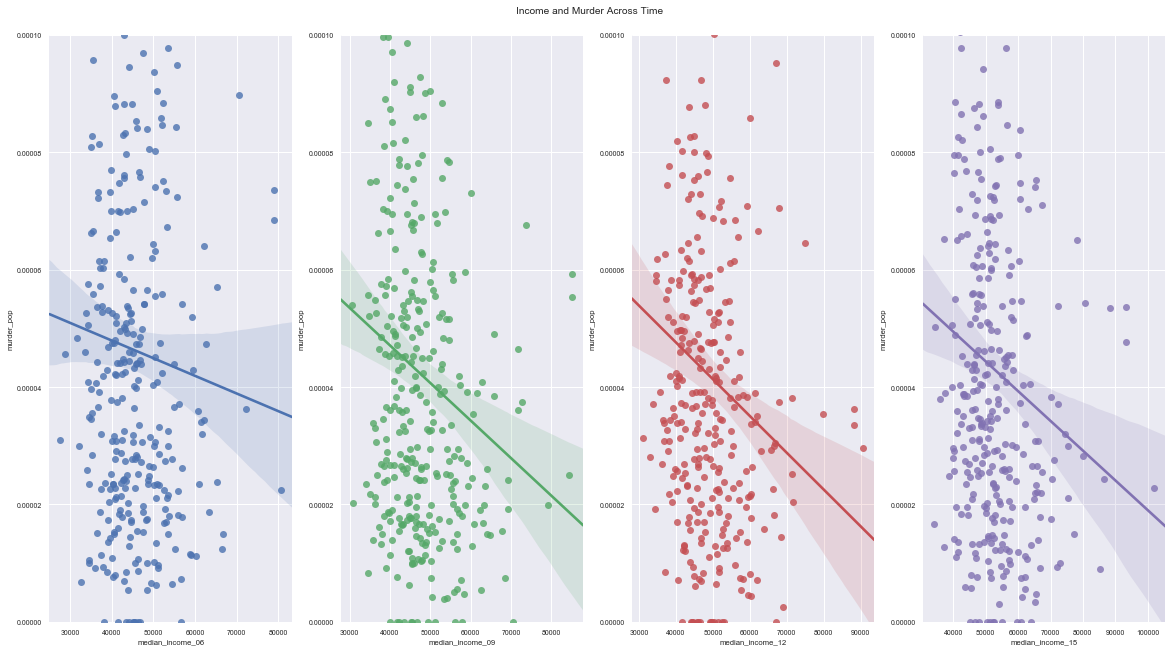

In [81]:
feature_x_time('Income and Murder Across Time', 'median_income_', option = 2)

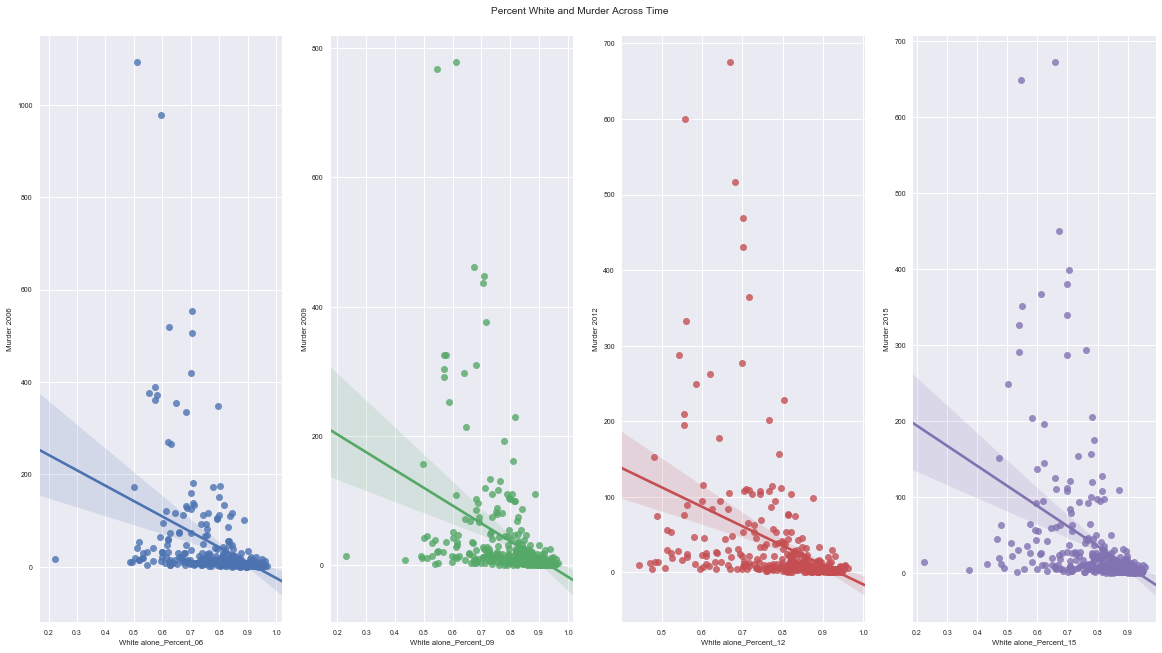

In [82]:
feature_x_time('Percent White and Murder Across Time', 'White alone_Percent_')

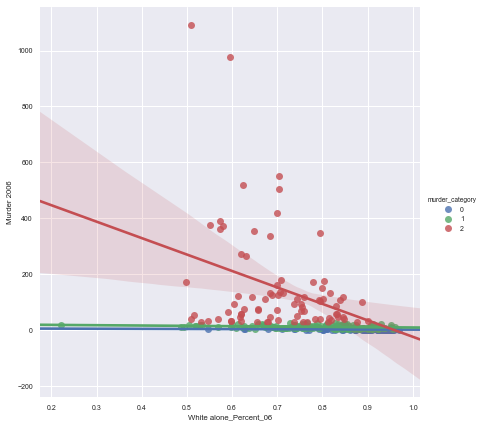

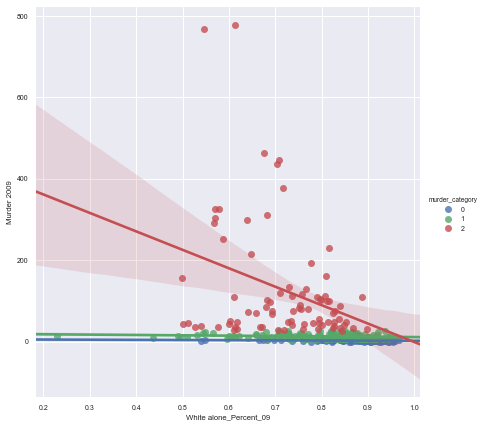

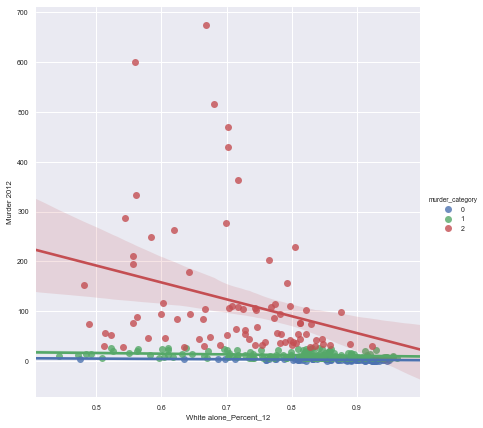

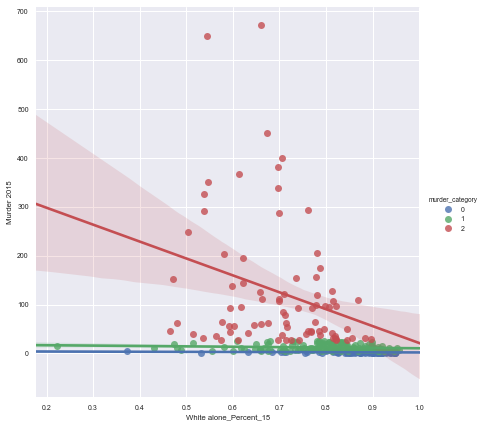

In [83]:
feature_x_time('Percent White and Murder Across Time', 'White alone_Percent_', option = 1)

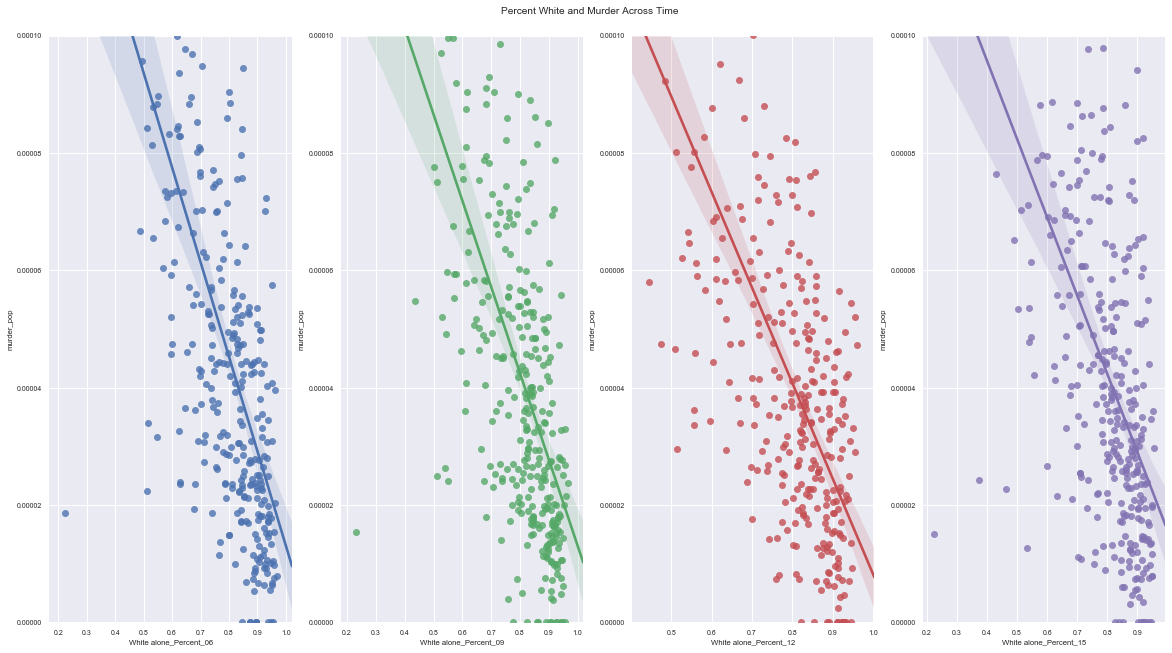

In [84]:
feature_x_time('Percent White and Murder Across Time', 'White alone_Percent_', option = 2)

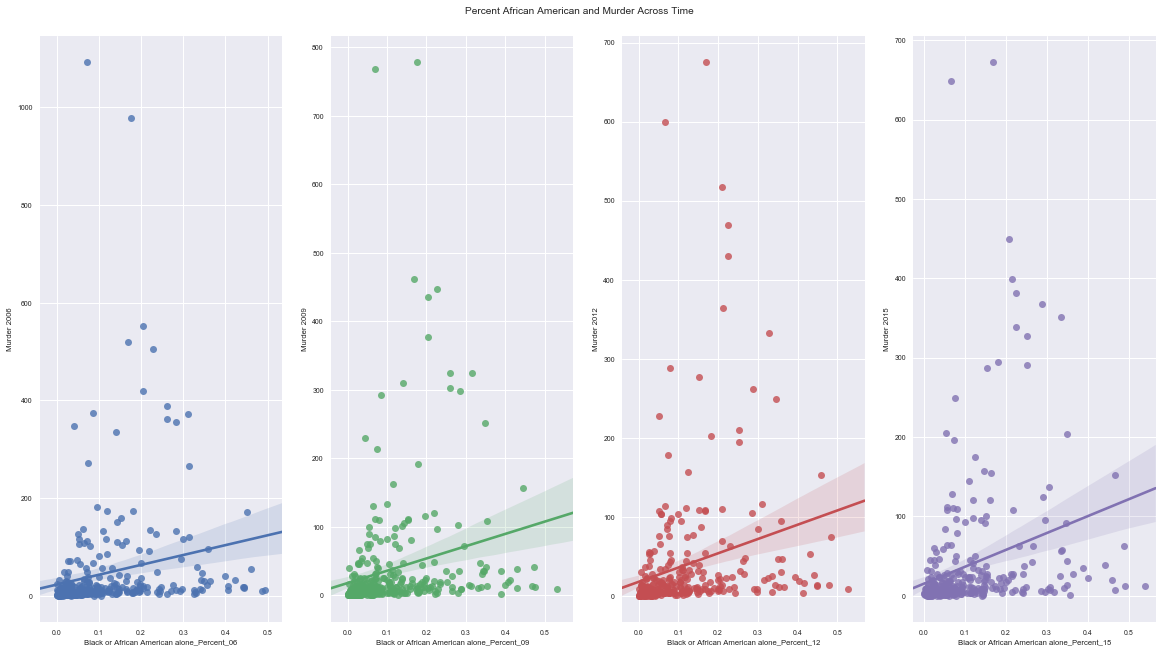

In [85]:
feature_x_time('Percent African American and Murder Across Time', 'Black or African American alone_Percent_')


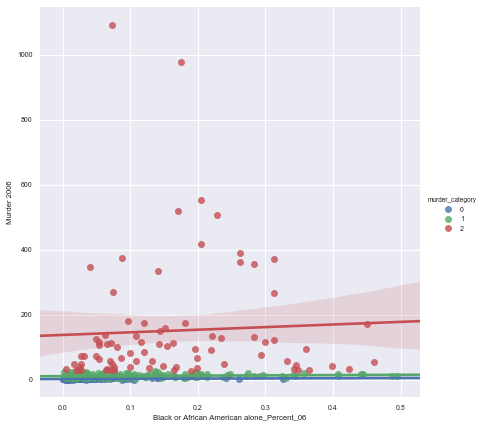

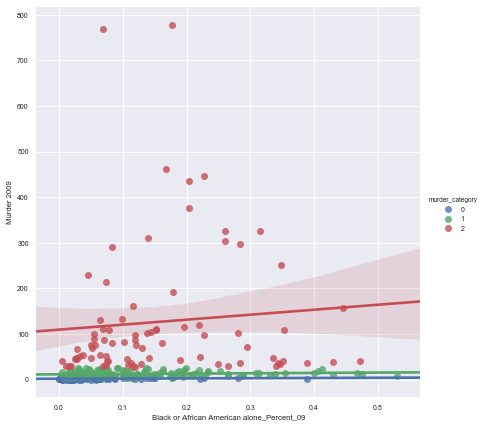

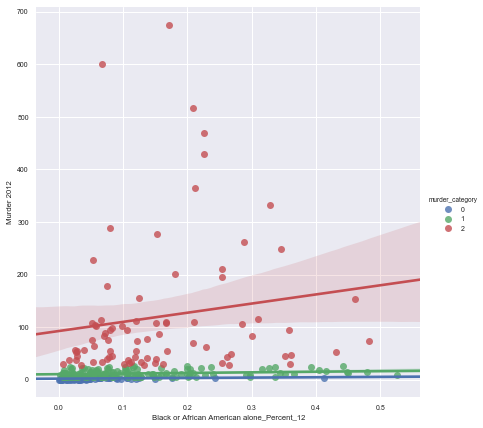

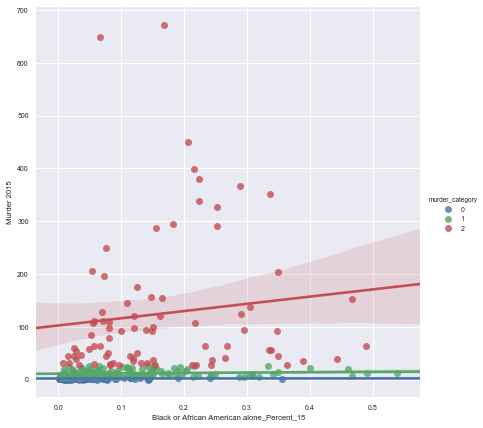

In [86]:
feature_x_time('Percent African American and Murder Across Time', 'Black or African American alone_Percent_', option = 1)


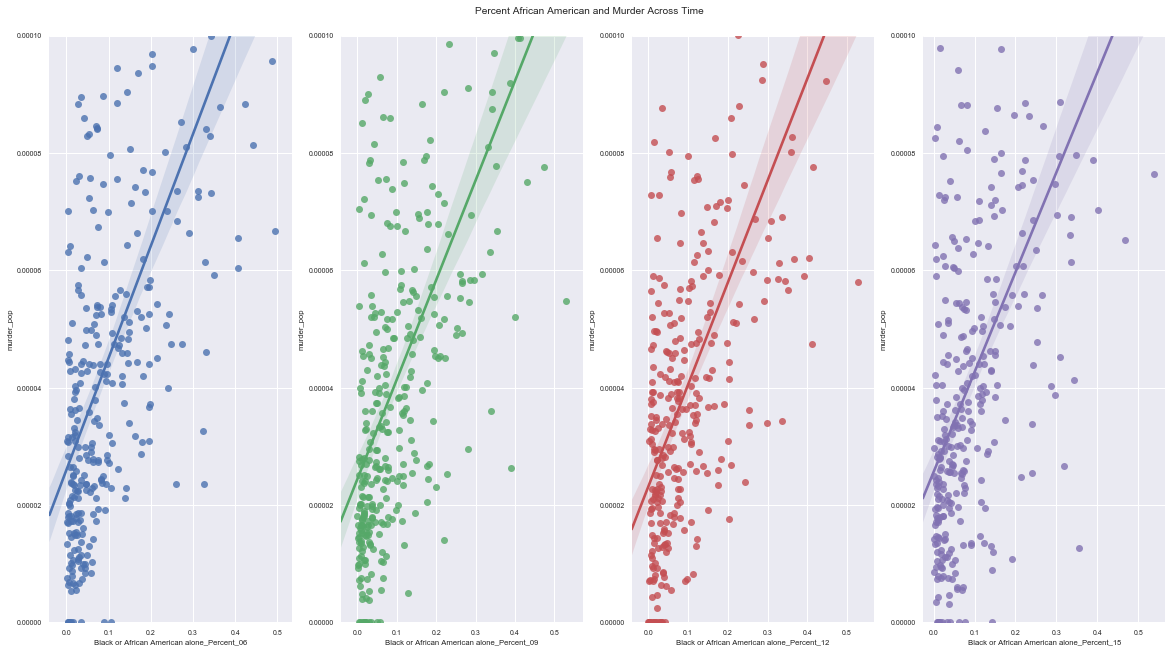

In [87]:
feature_x_time('Percent African American and Murder Across Time', 'Black or African American alone_Percent_', option = 2)

### Feature-Feature Correlation

Looks like multicollinearity will be an issue. We will address this through feature selection

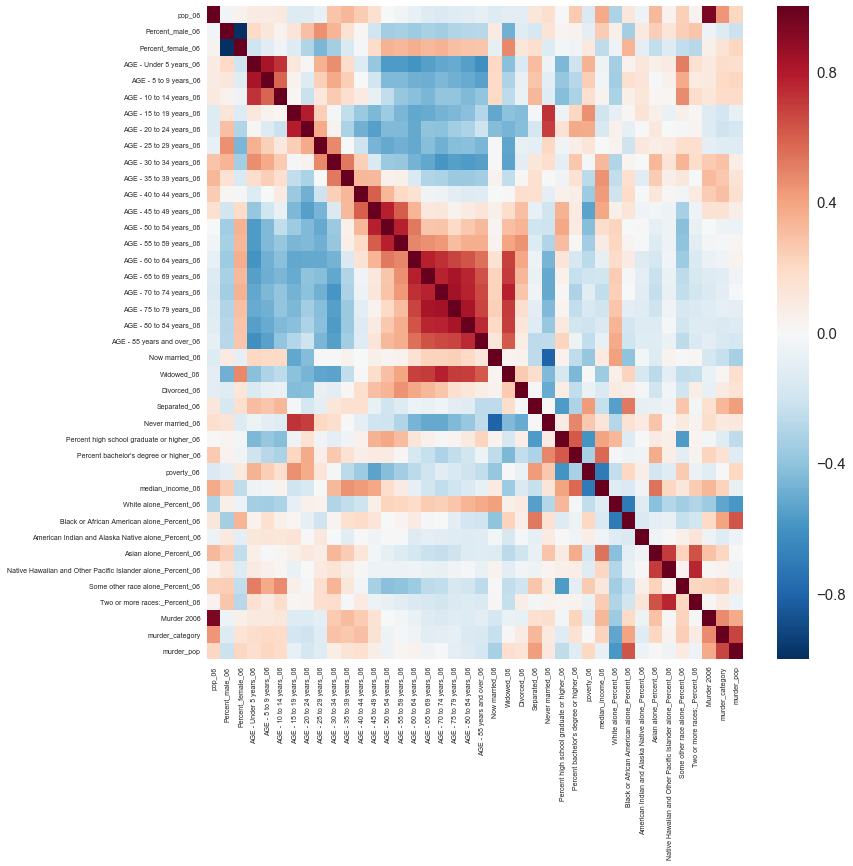

In [88]:
fig, ax = plt.subplots(figsize=(12, 12))

sns.set(font_scale = 1.5)
sns.heatmap(dict_df_year[2006].corr(), ax = ax)



In [89]:
# collapse age columns and drop specific columns
for i in range(2006, 2017):
    dict_df_year[i]['under_18_' + '%02d' % (i - 2000)] = dict_df_year[i]['AGE - Under 5 years_' + '%02d' % (i - 2000)] + dict_df_year[i]['AGE - 5 to 9 years_' + '%02d' % (i - 2000)] + dict_df_year[i]['AGE - 10 to 14 years_' + '%02d' % (i - 2000)] + dict_df_year[i]['AGE - 15 to 19 years_' + '%02d' % (i - 2000)]  
    dict_df_year[i]['20_to_40_' + '%02d' % (i - 2000)] = dict_df_year[i]['AGE - 20 to 24 years_' + '%02d' % (i - 2000)] + dict_df_year[i]['AGE - 25 to 29 years_' + '%02d' % (i - 2000)] + dict_df_year[i]['AGE - 30 to 34 years_' + '%02d' % (i - 2000)] + dict_df_year[i]['AGE - 35 to 39 years_' + '%02d' % (i - 2000)]  
    dict_df_year[i]['40_to_60_' + '%02d' % (i - 2000)] = dict_df_year[i]['AGE - 40 to 44 years_' + '%02d' % (i - 2000)] + dict_df_year[i]['AGE - 45 to 49 years_' + '%02d' % (i - 2000)] + dict_df_year[i]['AGE - 50 to 54 years_' + '%02d' % (i - 2000)] + dict_df_year[i]['AGE - 55 to 59 years_' + '%02d' % (i - 2000)]  
    dict_df_year[i]['60_above_' + '%02d' % (i - 2000)] = dict_df_year[i]['AGE - 60 to 64 years_' + '%02d' % (i - 2000)] + dict_df_year[i]['AGE - 65 to 69 years_' + '%02d' % (i - 2000)] + dict_df_year[i]['AGE - 70 to 74 years_' + '%02d' % (i - 2000)] + dict_df_year[i]['AGE - 75 to 79 years_' + '%02d' % (i - 2000)] + dict_df_year[i]['AGE - 80 to 84 years_' + '%02d' % (i - 2000)] + dict_df_year[i]['AGE - 85 years and over_' + '%02d' % (i - 2000)]  
    dict_df_year[i] = dict_df_year[i].drop(['AGE - Under 5 years_' + '%02d' % (i - 2000), 'AGE - 5 to 9 years_' + '%02d' % (i - 2000), 'AGE - 10 to 14 years_' + '%02d' % (i - 2000), 'AGE - 15 to 19 years_'  + '%02d' % (i - 2000), 'AGE - 20 to 24 years_' + '%02d' % (i - 2000), 'AGE - 25 to 29 years_' + '%02d' % (i - 2000), 'AGE - 30 to 34 years_' + '%02d' % (i - 2000), 'AGE - 35 to 39 years_' + '%02d' % (i - 2000), 'AGE - 40 to 44 years_' + '%02d' % (i - 2000), 'AGE - 45 to 49 years_' + '%02d' % (i - 2000), 'AGE - 50 to 54 years_' + '%02d' % (i - 2000), 'AGE - 55 to 59 years_' + '%02d' % (i - 2000), 'AGE - 60 to 64 years_' + '%02d' % (i - 2000), 'AGE - 65 to 69 years_' + '%02d' % (i - 2000), 'AGE - 70 to 74 years_' + '%02d' % (i - 2000), 'AGE - 75 to 79 years_' + '%02d' % (i - 2000), 'pop_'+ '%02d' % (i - 2000), 'murder_category'], axis = 1)

In [90]:
dict_df_year[2007].columns.tolist()

['Percent_male_07',
 'Percent_female_07',
 'AGE - 80 to 84 years_07',
 'AGE - 85 years and over_07',
 'Now married_07',
 'Widowed_07',
 'Divorced_07',
 'Separated_07',
 'Never married_07',
 'Percent high school graduate or higher_07',
 "Percent bachelor's degree or higher_07",
 'poverty_07',
 'median_income_07',
 'White alone_Percent_07',
 'Black or African American alone_Percent_07',
 'American Indian and Alaska Native alone_Percent_07',
 'Asian alone_Percent_07',
 'Native Hawaiian and Other Pacific Islander alone_Percent_07',
 'Some other race alone_Percent_07',
 'Two or more races:_Percent_07',
 'msa_name',
 'Murder 2007',
 'ID',
 'murder_pop',
 'under_18_07',
 '20_to_40_07',
 '40_to_60_07',
 '60_above_07']

### Beta for Each Year

In [94]:
from sklearn.preprocessing import MinMaxScaler

# def df_train_test(year, columns, y_name):
#     df = dict_df_year[year].dropna()
#     df_select = df[columns]
    
#     # split
#     msk = np.random.rand(len(df_select)) < .70
#     train = df_select[msk]
#     test = df_select[~msk]
    
#     # train
#     x_train = train.loc[:, train.columns != y_name]
#     y_train = train[[y_name]]
    
#     # test
#     x_test = test.loc[:, test.columns != y_name]
#     y_test = test[[y_name]]
    
#     x_columns = x_train.columns.tolist()
    
#     scaler = MinMaxScaler().fit(x_train)
#     x_train[x_columns] = scaler.transform(x_train)
#     x_test[x_columns] = scaler.transform(x_test)
    
#     return x_train, y_train, x_test, y_test


def preprocess(year, columns, y_name):
    df = dict_df_year[year].dropna()
    
    x_train = df[columns]
    y_train = df[[y_name]]
    
    df_scale = dict_df_year[2006].dropna()
    columns_scale = df_scale[['Percent_male_06', 'Percent_female_06', 'under_18_06', '20_to_40_06', '40_to_60_06', '60_above_06', 'Now married_06', 'Widowed_06', 'Divorced_06', 'Separated_06', 'Never married_06', 'Percent high school graduate or higher_06', "Percent bachelor's degree or higher_06", 'poverty_06', 'median_income_06', 'White alone_Percent_06', 'Black or African American alone_Percent_06', 'American Indian and Alaska Native alone_Percent_06', 'Asian alone_Percent_06', 'Native Hawaiian and Other Pacific Islander alone_Percent_06', 'Some other race alone_Percent_06', 'Two or more races:_Percent_06']]

    x_columns = x_train.columns.tolist()
    
    scaler = MinMaxScaler().fit(columns_scale)
    x_train[x_columns] = scaler.transform(x_train)
    return x_train, y_train

def more_terms(x_train, x_test, degree):
    columns = x_train.columns.tolist()
    poly = PolynomialFeatures(degree, interaction_only = False)
    
    x_trainpoly = poly.fit_transform(x_train)
    x_testpoly = poly.fit_transform(x_test)
    feature = poly.get_feature_names(columns)
    x_train_poly = pd.DataFrame(x_trainpoly, columns = feature)
    x_test_poly = pd.DataFrame(x_testpoly, columns = feature)
    return x_train_poly, x_test_poly
   


In [144]:
# put x_train, x_test, y_train, y_test in dicts with key = year
x_year = {}
y_year = {}

columns = ['Percent_male_' , 'Percent_female_', 'under_18_', '20_to_40_', '40_to_60_', '60_above_', 'Now married_', 'Widowed_', 'Divorced_', 'Separated_', 'Never married_', 'Percent high school graduate or higher_', "Percent bachelor's degree or higher_", 'poverty_', 'median_income_', 'White alone_Percent_', 'Black or African American alone_Percent_', 'American Indian and Alaska Native alone_Percent_', 'Asian alone_Percent_', 'Native Hawaiian and Other Pacific Islander alone_Percent_', 'Some other race alone_Percent_', 'Two or more races:_Percent_']



for year in range(2006, 2017):
    columns_year = []
    year_2 = '%02d' % (year - 2000)
    
    for column in columns:
        columns_year.append(column + year_2)
    
    xyear, yyear = preprocess(year, columns_year, 'murder_pop')
    
    x_year[year] = xyear
    y_year[year] = yyear

# done
collapsed age columns

make sure df contains the correct dependent variable (murder/ pop)

scatter the beta plots

standardize using 2006 minmax 

# not done

base model beta modeled 

ridge with beta modeled

lasso with beta modeled

model using 2015 (the works)

also using an averaged dataset like on comments mayb?

# Final Dataframe here!!!

x_year is a dictionary of dataframes with key = year and value equal to the standardized features (by 2006) of that year.

y _year is a dictionary of dataframes with key = year and value equal to the pop/count (y value) of that year

In [154]:
# x_train is x_year with key bounded by year 2006 to 2015 and y_train is y_year with key bounded by year 2006 to 2015

# x_test
x_year[2016]

# y test
y_year[2016]

murder_pop
0      0.000064
1      0.000058
2      0.000118
3      0.000020
4      0.000082
6      0.000026
7      0.000008
8      0.000053
10     0.000070
11     0.000005
14     0.000051
16     0.000068
18     0.000074
19     0.000034
20     0.000099
21     0.000141
24     0.000095
27     0.000066
31     0.000025
35     0.000025
36     0.000018
37     0.000003
39     0.000004
40     0.000015
41     0.000019
43     0.000049
45     0.000057
48     0.000046
49     0.000077
50     0.000095
..          ...
272    0.000053
273    0.000045
274    0.000039
275    0.000069
276    0.000090
277    0.000067
278    0.000048
279    0.000092
280    0.000075
282    0.000014
284    0.000055
285    0.000072
286    0.000094
287    0.000072
288    0.000026
290    0.000042
291    0.000039
296    0.000028
297    0.000065
298    0.000080
300    0.000060
302    0.000084
303    0.000043
304    0.000076
310    0.000052
323    0.000030
325    0.000051
328    0.000029
333    0.000016
335    0.000018

[197 rows x 1 columns]

In [155]:

# import warnings
# warnings.filterwarnings('ignore')


# from sklearn.linear_model import LassoCV
# from sklearn.linear_model import RidgeCV
# from sklearn.linear_model import LinearRegression

# # make dataframe to fill
# coefficients_lasso = pd.DataFrame()
# coefficients_ridge = pd.DataFrame()

# # add a column of column names
# coefficients_lasso['columns'] = columns
# coefficients_ridge['columns'] = columns


# for i in range(2006, 2016):

#     lasso = LassoCV().fit(x_year[i], y_year[i].values.reshape(-1, 1))
#     print(lasso.score(x_year[2016], y_year[2016]), i)
#     print(len(lasso.coef_))
#     coefficients_lasso[i] = lasso.coef_
    
#     ridge = RidgeCV().fit(x_year[i], y_year[i].values.reshape(-1, 1))

#     print(ridge.score(x_year[2016], y_year[2016]), i)
#     coefficients_ridge[i] = ridge.coef_


    






0.5029405692 2006
22
0.497132780567 2007
22
0.506006367613 2008
22
0.417038490377 2009
22
0.306765059128 2010
22
0.394008343673 2011
22
0.407741465502 2012
22
0.426204266228 2013
22
0.422721773064 2014
22
0.526721418614 2015
22


In [103]:
# coefficients_lasso = rename(coefficients_lasso.T)

In [104]:
# coefficients_lasso

Percent_male_ Percent_female_    under_18_    20_to_40_    40_to_60_  \
2006            -0               0            0 -1.49317e-05            0   
2007   2.50943e-05    -1.04111e-17  1.92756e-06 -1.34528e-05           -0   
2008            -0               0  2.07584e-05 -1.36077e-05            0   
2009             0              -0            0           -0           -0   
2010            -0               0            0 -5.53112e-06  3.75063e-06   
2011             0              -0            0 -1.89286e-05           -0   
2012             0              -0  5.80958e-06 -2.14276e-05            0   
2013            -0               0  1.02833e-05 -2.61565e-06            0   
2014            -0               0            0           -0  6.88676e-07   
2015  -2.82101e-05     4.19204e-18            0           -0  3.93652e-06   

        60_above_ Now married_     Widowed_    Divorced_   Separated_  \
2006           -0 -1.69852e-05            0  2.03434e-05           -0   
2007            0 -8.42573e-06  2.04615e-05  1.57046e-05  1.31315e-05   
2008           -0 -2.25398e-05  1.23661e-05  1.93731e-05            0   
2009           -0 -4.40681e-06   1.4339e-05  1.63023e-05           -0   
2010           -0 -1.17153e-05            0  4.54535e-06   4.8768e-08   
2011            0           -0           -0  1.39977e-05            0   
2012           -0 -1.52069e-05            0  4.08538e-06           -0   
2013           -0 -1.83317e-05            0  2.34959e-05 -1.35904e-05   
2014 -5.34658e-06 -1.82251e-05            0  1.04537e-05            0   
2015 -3.44654e-05 -1.33957e-05  8.36639e-06   2.6429e-05 -2.00197e-05   

                 ...             Percent bachelor's degree or higher_  \
2006             ...                                     -2.70367e-06   
2007             ...                                      3.47051e-06   
2008             ...                                                0   
2009             ...                                               -0   
2010             ...                                               -0   
2011             ...                                     -1.41982e-07   
2012             ...                                     -1.79613e-05   
2013             ...                                     -1.40219e-05   
2014             ...                                     -2.02628e-05   
2015             ...                                      -2.8213e-05   

         poverty_ median_income_ White alone_Percent_  \
2006           -0              0         -2.17475e-05   
2007  2.77259e-06             -0         -5.69725e-05   
2008 -2.66085e-06              0         -4.09759e-05   
2009  4.35632e-06             -0         -3.13785e-05   
2010            0             -0         -2.82884e-05   
2011  3.94939e-07   -1.13065e-05         -6.30831e-05   
2012  5.26042e-06             -0         -6.75628e-05   
2013            0             -0         -3.01597e-05   
2014            0             -0         -1.93426e-05   
2015 -1.40088e-05             -0          -2.8157e-05   

     Black or African American alone_Percent_  \
2006                              7.90579e-05   
2007                              7.20037e-05   
2008                              6.36316e-05   
2009                              5.71945e-05   
2010                              4.92701e-05   
2011                              4.53424e-05   
2012                              3.97075e-05   
2013                              5.21165e-05   
2014                              5.75451e-05   
2015                              6.82155e-05   

     American Indian and Alaska Native alone_Percent_ Asian alone_Percent_  \
2006                                               -0                    0   
2007                                      4.34504e-05                   -0   
2008                                                0                   -0   
2009                                                0                

(-4e-05, 3e-05)

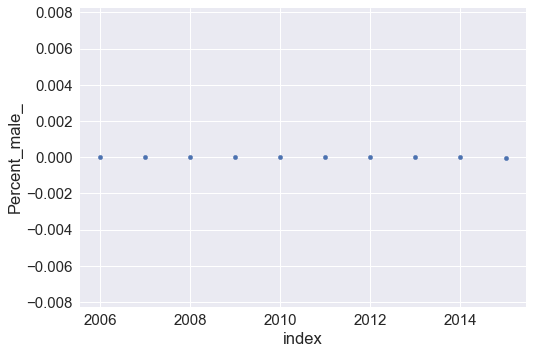

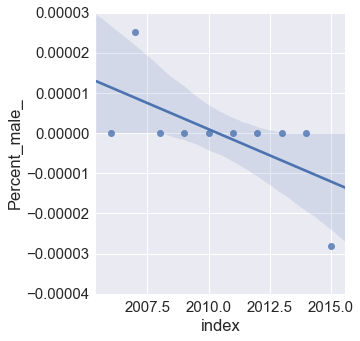

In [142]:
# sns.lmplot(x = 'index', y = 'Percent_male_', data= coefficients_lasso.reset_index(), fit_reg = True)

# sns.plt.ylim(-.00004, .00003)

In [152]:
# coefficients_lasso.plot(kind = 'scatter', x = np.array(range(2006, 2016)), y = 'Black or African American alone_Percent_')

In [ ]:
# # select columns
# base_model = ['Percent_male_06', 'Percent_female_06', 'AGE - Under 5 years_06', 'AGE - 5 to 9 years_06', 'AGE - 10 to 14 years_06', 'AGE - 15 to 19 years_06', 'AGE - 20 to 24 years_06', 'AGE - 25 to 29 years_06', 'AGE - 30 to 34 years_06', 'AGE - 35 to 39 years_06', 'AGE - 40 to 44 years_06', 'AGE - 45 to 49 years_06', 'AGE - 50 to 54 years_06', 'AGE - 55 to 59 years_06', 'AGE - 60 to 64 years_06','AGE - 65 to 69 years_06','AGE - 70 to 74 years_06','AGE - 75 to 79 years_06','AGE - 80 to 84 years_06','AGE - 85 years and over_06','median_income_06', 'Murder 2006']

# x_btrain, y_btrain, x_btest, y_btest = df_train_test(2006, base_model, 'Murder 2006')



In [ ]:
# basemodel = LinearRegression().fit(x_btrain, y_btrain)
# print('The base model test R2 for 2006 is', basemodel.score(x_btest, y_btest))

# x_btrainc = sm.add_constant(x_btrain)
# base = sm.OLS(y_btrain, x_btrainc).fit()


### Not Base Model

In [ ]:
# six = dict_df_year[2006].dropna()




In [ ]:
# six1 = six.drop(['murder_category', 'ID', 'murder_pop', 'msa_name'], axis = 1)

# six2 = six.drop(['murder_category', 'ID', 'Murder 2006', 'msa_name', 'pop_06'], axis = 1)

In [ ]:
# msk = np.random.rand(len(six1)) < 0.70
# df_train1 = six1[msk]
# df_test1 = six1[~msk]

# msk = np.random.rand(len(six2)) < 0.70
# df_train2 = six2[msk]
# df_test2 = six2[~msk]


In [ ]:
# x_train1 = df_train1.loc[:, df_train1.columns != 'Murder 2006']
# y_train1 = df_train1[['Murder 2006']]
# x_test1 = df_test1.loc[:, df_test1.columns != 'Murder 2006']
# y_test1 = df_test1[['Murder 2006']]

# x_train2 = df_train2.loc[:, df_train2.columns != 'murder_pop']
# y_train2 = df_train2[['murder_pop']]
# x_test2 = df_test2.loc[:, df_test2.columns != 'murder_pop']
# y_test2 = df_test2[['murder_pop']]


In [ ]:
# mean1 = x_train1.mean()
# std1 = x_train1.std()

# x_train1 = (x_train1 - mean1) / std1
# x_test1 = (x_test1 - mean1)/ std1

# mean2 = x_train2.mean()
# std2 = x_train2.std()

# x_train2 = (x_train2 - mean2)/ std2
# x_test2 = (x_test2 - mean2)/ std2



In [ ]:
# from sklearn.linear_model import LinearRegression

# regress1 = LinearRegression().fit(x_train1, y_train1)

# print(regress1.score(x_test1, y_test1))

# regress2 = LinearRegression().fit(x_train2, y_train2)

# print(regress2.score(x_test2, y_test2))





In [ ]:
# import statsmodels.api as sm

# xtrainc1 = sm.add_constant(x_train1)

# model1 = sm.OLS(y_train1, xtrainc1).fit()

# print(model1.summary())

# xtrainc2 = sm.add_constant(x_train2)

# model2 = sm.OLS(y_train2, xtrainc2).fit()

# print(model2.summary())



In [ ]:
# from sklearn.linear_model import LassoCV


# lasso1 = LassoCV().fit(x_train1, y_train.values.reshape(-1, 1))

# print(lasso1.score(x_test1, y_test1))

# for i, d in zip(lasso1.coef_, x_train1.columns.tolist()):
#     print(i,d)
    



In [ ]:
# lasso2 = LassoCV().fit(x_train2, y_train2.values.reshape(-1, 1))

# print(lasso2.score(x_test2, y_test2))

# for i, d in zip(lasso2.coef_, x_train2.columns.tolist()):
#     print(i,d)

